##  데이콘 tscv, Optuna 필사

https://dacon.io/en/codeshare/2876

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import seaborn as sns
from IPython.display import Image
import plotly.express as px # ploty
import plotly.graph_objects as go

from tqdm import tqdm
import time

#한글폰트설정
plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_rows', 100)


#모델
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier, plot_importance
import lightgbm 


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import Lars,LassoLars,LassoLarsCV

# import optuna
# from optuna.integration import XGBoostPruningCallback

pd.options.display.float_format = '{:.2f}'.format



import warnings
warnings.filterwarnings(action='ignore')

import gc, sys
gc.enable() # 자동 가비지 수거 활성화

In [ ]:
# 한글 폰트 확인
import matplotlib.font_manager as fm
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'NanumBarun' in f.name]

[('NanumBarunGothic',
  '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'),
 ('NanumBarunGothic', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')]

# 데이터 불러오기

In [ ]:
base_path = '/content/drive/MyDrive/이어드림스쿨/Project/Final_project/2021 농산물 예측대회 AI 경진대회/2021 농산물 가격예측 AI 경진대회/프로젝트 data/'

In [ ]:
df = pd.read_parquet(base_path + 'modeling_data1(완).parquet')

In [ ]:
df.head()

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,온도(최고),지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균)
0,2016-01-01,사과,후지,충북 충주,26000.00,15.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
1,2016-01-01,사과,후지,충북 충주,20000.00,40.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
2,2016-01-01,사과,후지,충북 충주,10500.00,14.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
3,2016-01-01,사과,후지,충북 충주,210000.00,240.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
4,2016-01-01,사과,후지,충북 충주,175000.00,140.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32


In [ ]:
df_apple = df[df.PUM_NM == '사과']
df_apple

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,온도(최고),지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균)
0,2016-01-01,사과,후지,충북 충주,26000.00,15.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
1,2016-01-01,사과,후지,충북 충주,20000.00,40.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
2,2016-01-01,사과,후지,충북 충주,10500.00,14.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
3,2016-01-01,사과,후지,충북 충주,210000.00,240.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
4,2016-01-01,사과,후지,충북 충주,175000.00,140.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18407159,2020-09-28,사과,홍로,충남 서산,170000.00,50.00,2020,9,28,0,...,23.30,11.60,20.62,43.70,0.43,88.00,0.00,0.00,7.80,0.33
18407160,2020-09-28,사과,홍로,충남 서산,532000.00,140.00,2020,9,28,0,...,23.30,11.60,20.62,43.70,0.43,88.00,0.00,0.00,7.80,0.33
18407163,2020-09-28,사과,홍로,충남 서산,1248000.00,240.00,2020,9,28,0,...,23.30,11.60,20.62,43.70,0.43,88.00,0.00,0.00,7.80,0.33
18407164,2020-09-28,사과,홍로,충남 서산,1056000.00,160.00,2020,9,28,0,...,23.30,11.60,20.62,43.70,0.43,88.00,0.00,0.00,7.80,0.33


In [ ]:
apple = df[df.PUM_NM == '사과']
apple = apple.groupby(['SALEDATE']).mean()
apple['mean_price']=apple['TOT_AMT']/apple['TOT_QTY']
# df_apple=df_apple.drop(columns=['TOT_AMT','TOT_QTY'])
apple = apple.reset_index()
apple = apple.round()
apple.head()

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
0,2016-01-01,100487.00,79.00,2016.00,1.00,1.00,4.00,1189.00,323.00,576369.00,...,-8.00,-2.00,7.00,1.00,68.00,0.00,0.00,7.00,0.00,1267.00
1,2016-01-02,302868.00,117.00,2016.00,1.00,2.00,5.00,1189.00,323.00,576369.00,...,-4.00,1.00,10.00,1.00,66.00,0.00,0.00,5.00,0.00,2594.00
2,2016-01-04,311936.00,168.00,2016.00,1.00,4.00,0.00,1187.00,323.00,576369.00,...,-3.00,1.00,10.00,2.00,55.00,0.00,0.00,6.00,0.00,1860.00
3,2016-01-05,265467.00,158.00,2016.00,1.00,5.00,1.00,1185.00,316.00,576369.00,...,-5.00,-2.00,5.00,1.00,37.00,0.00,0.00,2.00,0.00,1676.00
4,2016-01-06,273227.00,162.00,2016.00,1.00,6.00,2.00,1184.00,312.00,576369.00,...,-8.00,-2.00,6.00,2.00,49.00,0.00,0.00,7.00,0.00,1688.00


## 사과
- time series Cross validation
- hyper-parameter tuning(Optuna) 까지 진행

In [ ]:
# 함수화

def split_train_and_test(df, date, week):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train = df[df['SALEDATE'] < date]
    test = df[df['SALEDATE'] >= date]
    del train['SALEDATE']
    del test['SALEDATE']
    y_train = train.pop(f'{week}week')
    x_train=train.copy()
    y_test = test.pop(f'{week}week')
    x_test=test.copy()
    return x_train,y_train,x_test,y_test

def eval_model(y_test,pred):
    y_true, y_pred = np.array(y_test), np.array(pred)
    mae = mean_absolute_error(y_true, pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('mae:',mae,'mape:',mape, 'mse:',mse)
    return mae, mape, mse

#시각화 그래프 
def eval_visul(y_test,pred,title,week):
    y_test=y_test.reset_index()[f'{week}week']
    plt.figure(figsize=(20,5))
    plt.title(title, fontsize = 25)
    plt.plot(y_test, label='true')
    plt.plot(pred, label='pred')
    plt.legend()
    plt.show()
    eval_model(y_test,pred)

def selcet_pum(df_apple,pum):
    #7가지 품목중 1가지를 집중해서 살펴보기 위해 배추를 기준으로 데이터 추출
    df_apple=df[df['PUM_NM']==pum]
    #기본만
    # df_apple=df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT',
    #     'TOT_QTY']]
    df_apple=df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM',  'TOT_AMT',
       'TOT_QTY', 'year', 'month', 'day', 'weekday', 'domestic_mean',
       'abroad_mean', 'output', 'area', '소비자물가지수']]
    return df_apple

def mean_price(df_apple):
    #날짜기준으로 데이터 평균 계산
    df_apple=df_apple.groupby(['SALEDATE']).mean()
    #kg당 가격 산출
    df_apple['mean_price']=df_apple['TOT_AMT']/df_apple['TOT_QTY']
    #사용된 총금액과 총거래량은 제거
    df_apple=df_apple.drop(columns=['TOT_AMT','TOT_QTY'])
    df_apple=df_apple.reset_index()
    df_apple = df_apple.round()
    #날짜 컬럼 추가
    # df_apple['year'] = df_apple['SALEDATE'].dt.year
    # df_apple['month'] = df_apple['SALEDATE'].dt.month
    # df_apple['day'] = df_apple['SALEDATE'].dt.day
    # df_apple['weekday'] = df_apple['SALEDATE'].dt.weekday
    return df_apple

#n주일 후 가격을 예측하는 컬럼을 추가 
#df-> 예측기간 가격이 0으로 나오는 값 제외, 따로 변수로 지정
def forcast_week(df,week):
    df[f'{week}week']=0
    
    for index in range(len(df)):
        try:df[f'{week}week'][index] = df['mean_price'][index+7*week]
        except:continue
    df_week=df.iloc[-7*week:]
    df = df.drop(df.iloc[-7*week:].index)
    return df, df_week


## time lag는 보류

# #최대 28일 전까지 가격 데이터를 컬럼에 추가
# #시계열 데이터의 분포를 학습시키기 위해
# def train_serise(df_apple):
#     for lag in range(1,29):
#         df_apple[f'p_lag_{lag}'] = -1
#         #df_apple[f'q_lag_{lag}'] = -1
#         for index in range(lag, len(df_apple)):
#             df_apple.loc[index, f'p_lag_{lag}'] = df_apple['mean_price'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
#             #df_apple.loc[index, f'q_lag_{lag}'] = df_apple['TOT_QTY'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
#     return df_apple


In [ ]:
# 함수화

def baseline_modeling(df_pum) : 
    # df_pum=selcet_pum(df, pum)
    # display(pum, df_pum.head(2))
    # df_pum=mean_price(df_pum)
    #몇주를 예상할지
    #def forcast_week(df,week):
    df_pum,df_1week=forcast_week(df_pum,1)

    display(df_pum.head(2))
    # df_pum=train_serise(df_pum) # 보류
    # 데이터프레임 테스트를 위해 나눌 기준일, 몇주 예상
    #def split_train_and_test(df, date,week):
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

    # # prediction vs actual
    # # forcast_week=1
    # eval_visul(y_test,pred,f'{pum} 품종 Linear Regression',1)
    # eval_visul(y_test,pred2,f'{pum} 품종 Lasso', 1)
    # eval_visul(y_test,pred3,f'{pum} 품종 Ridge', 1)
    # eval_visul(y_test,pred4,f'{pum} 품종 LGB Regressor', 1)
    # eval_visul(y_test,pred5,f'{pum} 품종 XGB Regressor',1)
    # eval_visul(y_test,pred6,f'{pum} 품종 RandomForest Regressor',1)

In [ ]:
train_X, test_X, train_y, test_y = baseline_modeling(apple)

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,...,지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price,1week
0,2016-01-01,100487.00,79.00,2016.00,1.00,1.00,4.00,1189.00,323.00,576369.00,...,-2.00,7.00,1.00,68.00,0.00,0.00,7.00,0.00,1267.00,1644
1,2016-01-02,302868.00,117.00,2016.00,1.00,2.00,5.00,1189.00,323.00,576369.00,...,1.00,10.00,1.00,66.00,0.00,0.00,5.00,0.00,2594.00,1779


(1159, 24) (1159,) (314, 24) (314,)


In [ ]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1159, 24), (314, 24), (1159,), (314,))

### Time Series Cross validation

In [ ]:
##4.2 MAPE 구현

# #방법 1) function으로 구현
# def MAPE(y_true, y_pred):
# 	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAPE(y_true, y_pred)
# #방법 2) sklearn.metrics의 method로 구현
# from sklearn.metrics import mean_absolute_percentage_error

# mean_absolute_percentage_error(y_true, y_pred)

In [ ]:
def MAPE(y, y_pred):
    mape = mean_absolute_percentage_error(y, y_pred)
    return mape

def mape_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def print_mape_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
def MAPE(y, y_pred):
    mape = mean_absolute_percentage_error(y, y_pred)
    return mape

def mape_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def print_mape_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [ ]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_mape_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 206.95it/s]


1 FOLDS: LinearRegression MAPE: 0.2643
2 FOLDS: LinearRegression MAPE: 0.2016
3 FOLDS: LinearRegression MAPE: 0.3030
4 FOLDS: LinearRegression MAPE: 0.0863
5 FOLDS: LinearRegression MAPE: 0.1265
6 FOLDS: LinearRegression MAPE: 0.1860
7 FOLDS: LinearRegression MAPE: 0.1274
8 FOLDS: LinearRegression MAPE: 0.1364
9 FOLDS: LinearRegression MAPE: 0.2889
10 FOLDS: LinearRegression MAPE: 0.1944

LinearRegression mean MAPE: 0.1915


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 145.77it/s]


1 FOLDS: Ridge MAPE: 0.1759
2 FOLDS: Ridge MAPE: 0.2310
3 FOLDS: Ridge MAPE: 0.2612
4 FOLDS: Ridge MAPE: 0.0859
5 FOLDS: Ridge MAPE: 0.1253
6 FOLDS: Ridge MAPE: 0.1860
7 FOLDS: Ridge MAPE: 0.1266
8 FOLDS: Ridge MAPE: 0.1358
9 FOLDS: Ridge MAPE: 0.2720
10 FOLDS: Ridge MAPE: 0.1939

Ridge mean MAPE: 0.1794


Lasso Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 57.09it/s]


1 FOLDS: Lasso MAPE: 0.2638
2 FOLDS: Lasso MAPE: 0.2020
3 FOLDS: Lasso MAPE: 0.3013
4 FOLDS: Lasso MAPE: 0.0863
5 FOLDS: Lasso MAPE: 0.1291
6 FOLDS: Lasso MAPE: 0.1860
7 FOLDS: Lasso MAPE: 0.1274
8 FOLDS: Lasso MAPE: 0.1346
9 FOLDS: Lasso MAPE: 0.2884
10 FOLDS: Lasso MAPE: 0.1943

Lasso mean MAPE: 0.1913


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 128.89it/s]


1 FOLDS: ElasticNet MAPE: 0.1645
2 FOLDS: ElasticNet MAPE: 0.2255
3 FOLDS: ElasticNet MAPE: 0.1757
4 FOLDS: ElasticNet MAPE: 0.0831
5 FOLDS: ElasticNet MAPE: 0.1210
6 FOLDS: ElasticNet MAPE: 0.1622
7 FOLDS: ElasticNet MAPE: 0.1264
8 FOLDS: ElasticNet MAPE: 0.1324
9 FOLDS: ElasticNet MAPE: 0.1211
10 FOLDS: ElasticNet MAPE: 0.1901

ElasticNet mean MAPE: 0.1502


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 132.65it/s]


1 FOLDS: DecisionTreeRegressor MAPE: 0.1732
2 FOLDS: DecisionTreeRegressor MAPE: 0.1945
3 FOLDS: DecisionTreeRegressor MAPE: 0.1034
4 FOLDS: DecisionTreeRegressor MAPE: 0.1495
5 FOLDS: DecisionTreeRegressor MAPE: 0.1725
6 FOLDS: DecisionTreeRegressor MAPE: 0.0912
7 FOLDS: DecisionTreeRegressor MAPE: 0.1202
8 FOLDS: DecisionTreeRegressor MAPE: 0.2283
9 FOLDS: DecisionTreeRegressor MAPE: 0.2591
10 FOLDS: DecisionTreeRegressor MAPE: 0.2453

DecisionTreeRegressor mean MAPE: 0.1737


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


1 FOLDS: RandomForestRegressor MAPE: 0.1600
2 FOLDS: RandomForestRegressor MAPE: 0.2497
3 FOLDS: RandomForestRegressor MAPE: 0.0789
4 FOLDS: RandomForestRegressor MAPE: 0.0887
5 FOLDS: RandomForestRegressor MAPE: 0.1391
6 FOLDS: RandomForestRegressor MAPE: 0.0828
7 FOLDS: RandomForestRegressor MAPE: 0.1220
8 FOLDS: RandomForestRegressor MAPE: 0.1939
9 FOLDS: RandomForestRegressor MAPE: 0.1800
10 FOLDS: RandomForestRegressor MAPE: 0.2068

RandomForestRegressor mean MAPE: 0.1502


XGBRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.79it/s]

[10:59:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:01,  4.58it/s]

[10:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:01,  4.09it/s]

[10:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:01,  3.58it/s]

[10:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.17it/s]

[10:59:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  60%|██████    | 6/10 [00:01<00:01,  2.65it/s]

[10:59:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  70%|███████   | 7/10 [00:02<00:01,  2.37it/s]

[10:59:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  80%|████████  | 8/10 [00:03<00:00,  2.11it/s]

[10:59:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  90%|█████████ | 9/10 [00:03<00:00,  1.84it/s]

[10:59:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


1 FOLDS: XGBRegressor MAPE: 0.1854
2 FOLDS: XGBRegressor MAPE: 0.3925
3 FOLDS: XGBRegressor MAPE: 0.1313
4 FOLDS: XGBRegressor MAPE: 0.1203
5 FOLDS: XGBRegressor MAPE: 0.1395
6 FOLDS: XGBRegressor MAPE: 0.0903
7 FOLDS: XGBRegressor MAPE: 0.1697
8 FOLDS: XGBRegressor MAPE: 0.2439
9 FOLDS: XGBRegressor MAPE: 0.1491
10 FOLDS: XGBRegressor MAPE: 0.2103

XGBRegressor mean MAPE: 0.1832


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.33it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1693
2 FOLDS: LGBMRegressor MAPE: 0.3173
3 FOLDS: LGBMRegressor MAPE: 0.0876
4 FOLDS: LGBMRegressor MAPE: 0.1172
5 FOLDS: LGBMRegressor MAPE: 0.1540
6 FOLDS: LGBMRegressor MAPE: 0.1002
7 FOLDS: LGBMRegressor MAPE: 0.1421
8 FOLDS: LGBMRegressor MAPE: 0.2701
9 FOLDS: LGBMRegressor MAPE: 0.2086
10 FOLDS: LGBMRegressor MAPE: 0.2033

LGBMRegressor mean MAPE: 0.1770


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.19
1,Ridge,0.18
2,Lasso,0.19
3,ElasticNet,0.15
4,DecisionTreeRegressor,0.17
5,RandomForestRegressor,0.15
6,XGBRegressor,0.18
7,LGBMRegressor,0.18


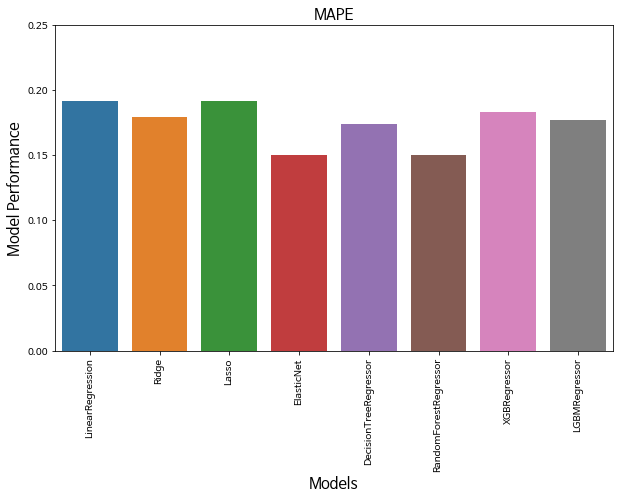

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.25)
plt.title('MAPE', fontsize=15)
plt.show()

#### 기본 모델 사용

In [ ]:
reg2 = LinearRegression()
ridge2 = Ridge()
lasso2 = Lasso()
Enet2 = ElasticNet()
DTree2 = DecisionTreeRegressor()
rf2 = RandomForestRegressor()
model_xgb2 = XGBRegressor()
model_lgb2 = LGBMRegressor()

In [ ]:
# 기본 모델로

models = []
scores = []
for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
    model_name, mean_score = print_mape_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 87.27it/s]


1 FOLDS: LinearRegression MAPE: 0.1681
2 FOLDS: LinearRegression MAPE: 0.1134
3 FOLDS: LinearRegression MAPE: 0.1416
4 FOLDS: LinearRegression MAPE: 0.1336
5 FOLDS: LinearRegression MAPE: 0.2101

LinearRegression mean MAPE: 0.1533


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 170.16it/s]


1 FOLDS: Ridge MAPE: 0.1608
2 FOLDS: Ridge MAPE: 0.1101
3 FOLDS: Ridge MAPE: 0.1405
4 FOLDS: Ridge MAPE: 0.1336
5 FOLDS: Ridge MAPE: 0.2024

Ridge mean MAPE: 0.1495


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 117.81it/s]


1 FOLDS: Lasso MAPE: 0.1524
2 FOLDS: Lasso MAPE: 0.1051
3 FOLDS: Lasso MAPE: 0.1238
4 FOLDS: Lasso MAPE: 0.1335
5 FOLDS: Lasso MAPE: 0.1838

Lasso mean MAPE: 0.1397


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 161.17it/s]


1 FOLDS: ElasticNet MAPE: 0.1507
2 FOLDS: ElasticNet MAPE: 0.1073
3 FOLDS: ElasticNet MAPE: 0.1165
4 FOLDS: ElasticNet MAPE: 0.1398
5 FOLDS: ElasticNet MAPE: 0.1258

ElasticNet mean MAPE: 0.1280


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 70.67it/s]


1 FOLDS: DecisionTreeRegressor MAPE: 0.1497
2 FOLDS: DecisionTreeRegressor MAPE: 0.1970
3 FOLDS: DecisionTreeRegressor MAPE: 0.1505
4 FOLDS: DecisionTreeRegressor MAPE: 0.1717
5 FOLDS: DecisionTreeRegressor MAPE: 0.3194

DecisionTreeRegressor mean MAPE: 0.1977


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.87it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1588
2 FOLDS: RandomForestRegressor MAPE: 0.1190
3 FOLDS: RandomForestRegressor MAPE: 0.0823
4 FOLDS: RandomForestRegressor MAPE: 0.1425
5 FOLDS: RandomForestRegressor MAPE: 0.2233

RandomForestRegressor mean MAPE: 0.1452


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[00:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:01,  5.52it/s]

[00:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.04it/s]


[00:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1613
2 FOLDS: XGBRegressor MAPE: 0.1260
3 FOLDS: XGBRegressor MAPE: 0.0820
4 FOLDS: XGBRegressor MAPE: 0.1509
5 FOLDS: XGBRegressor MAPE: 0.1617

XGBRegressor mean MAPE: 0.1364


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.67it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1321
2 FOLDS: LGBMRegressor MAPE: 0.1154
3 FOLDS: LGBMRegressor MAPE: 0.0832
4 FOLDS: LGBMRegressor MAPE: 0.1489
5 FOLDS: LGBMRegressor MAPE: 0.2590

LGBMRegressor mean MAPE: 0.1477


In [ ]:
# 5folds 대략 1년
result_df2 = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df2

,Model,Score
0,LinearRegression,0.15
1,Ridge,0.15
2,Lasso,0.14
3,ElasticNet,0.13
4,DecisionTreeRegressor,0.20
5,RandomForestRegressor,0.15
6,XGBRegressor,0.14
7,LGBMRegressor,0.15


In [ ]:
# 10folds 대략 4.5개월
result_df2 = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df2

,Model,Score
0,LinearRegression,0.19
1,Ridge,0.18
2,Lasso,0.17
3,ElasticNet,0.14
4,DecisionTreeRegressor,0.23
5,RandomForestRegressor,0.17
6,XGBRegressor,0.20
7,LGBMRegressor,0.17


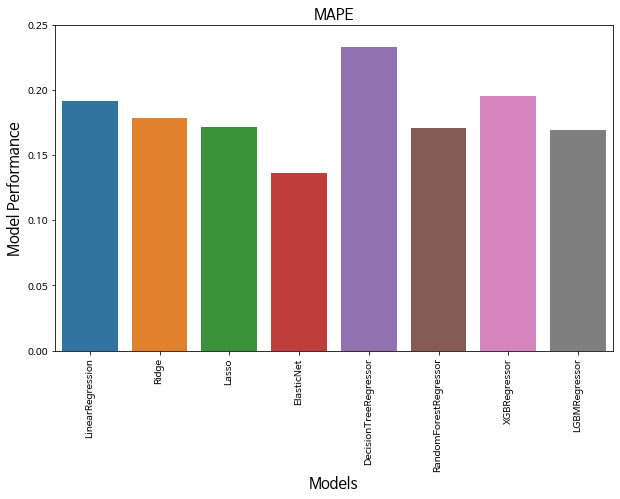

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df2['Model'], y=result_df2['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.25)
plt.title('MAPE', fontsize=15)
plt.show()

### LightGBM Optuna 사용

train test를 train, validation set 8 : 2로 나누어 진행

In [ ]:
cut = int(len(train_X)*0.8)

h_train_X = train_X[:cut]
h_train_y = train_y[:cut]

h_valid_X = train_X[cut:]
h_valid_y = train_y[cut:]

print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(927, 24) (927,) (232, 24) (232,)


In [ ]:
h_train_X.head()

,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,area,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
0,-2.26,-1.88,-0.50,-0.83,-1.00,0.33,-0.88,-1.24,0.31,0.54,...,-0.79,-0.86,-0.88,0.00,-0.12,0.00,0.00,0.17,0.00,-1.25
1,0.09,-1.00,-0.50,-0.83,-0.93,0.67,-0.88,-1.24,0.31,0.54,...,-0.58,-0.71,-0.76,0.00,-0.21,0.00,0.00,-0.17,0.00,1.31
2,0.20,0.19,-0.50,-0.83,-0.80,-1.00,-0.90,-1.24,0.31,0.54,...,-0.53,-0.71,-0.76,1.00,-0.67,0.00,0.00,0.00,0.00,-0.11
3,-0.34,-0.05,-0.50,-0.83,-0.73,-0.67,-0.91,-1.29,0.31,0.54,...,-0.63,-0.86,-0.96,0.00,-1.42,0.00,0.00,-0.67,0.00,-0.46
4,-0.25,0.05,-0.50,-0.83,-0.67,-0.33,-0.92,-1.32,0.31,0.54,...,-0.79,-0.86,-0.92,1.00,-0.92,0.00,0.00,0.17,0.00,-0.44


- optuna.trial.Trial.suggest_categorical() : 리스트 범위 내에서 값을 선택한다.
- optuna.trial.Trial.suggest_int() : 범위 내에서 정수형 값을 선택한다.
- optuna.trial.Trial.suggest_float() : 범위 내에서 소수형 값을 선택한다.
- optuna.trial.Trial.suggest_uniform() : 범위 내에서 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_loguniform() : 범위 내에서 로그 함수 값을 선택한다.

In [ ]:
# LightGBM Optuna 사용

from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    # dtrain = LGBMRegressor.Dataset(h_train_X, label=h_train_y)
    # dtest = LGBMRegressor.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mape', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    mape = MAPE(h_valid_y, lgb_model.predict(h_valid_X))
    return mape
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-10-11 10:43:48,535] A new study created in memory with name: no-name-501aa7cb-2d36-4d86-ad7d-ac743caa95e4
[I 2022-10-11 10:43:49,123] Trial 0 finished with value: 0.1713469943105755 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.1713469943105755.
[I 2022-10-11 10:43:50,419] Trial 1 finished with value: 0.171324337907308 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.171324337907308.
[I 2022-10-11 10:43:50,474] Trial 2 finished with value: 0.15022415438769207 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.15022415438769207.
[I 2022-10-11 10:43:50,714] Trial 3 finished with 

In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.13892977857934638,
params {'max_depth': 5, 'learning_rate': 0.0016730262534992444, 'n_estimators': 2156, 'min_child_samples': 73, 'subsample': 0.65205892016222}


LightGBM mape 값이 0.177 -> 0.138로 hyper-parameter tuning 이후에 많이 떨어진 것을 확인

In [ ]:
final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_X)

In [ ]:
final_lgb_pred.shape

(314,)

In [ ]:
test_y.shape

(314,)

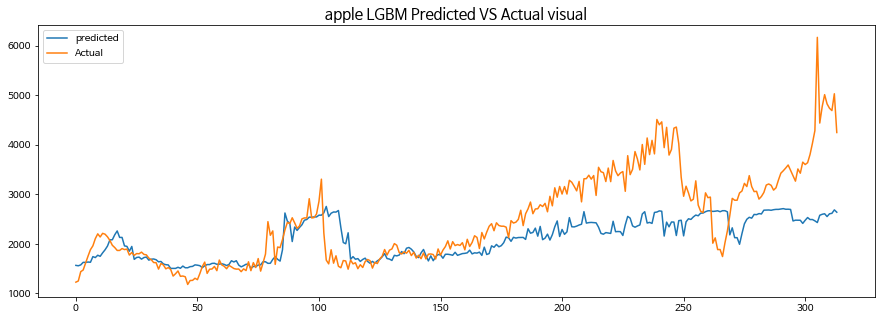

In [ ]:
# 실제값 예측값 시각화

plt.figure(figsize = (15,5))
plt.plot(final_lgb_pred, label = 'predicted')
plt.plot(np.array(test_y), label = 'Actual')
plt.legend()
plt.title('apple LGBM Predicted VS Actual visual', fontsize = 15)
plt.show()

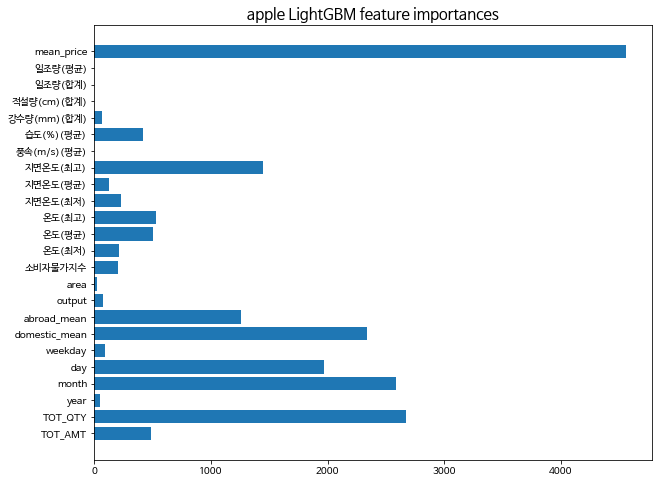

In [ ]:
# LightGBM feature importances 시각화

plt.figure(figsize = (10,8))
plt.barh(train_X.columns, final_lgb_model.feature_importances_)
plt.title('apple LightGBM feature importances', fontsize = 15)
plt.show()

## 시계열 데이터 분포 feature 추가

In [ ]:
apple.corr()

In [ ]:
def train_serise(df_apple):
    for lag in range(1,10):
        df_apple[f'p_lag_{lag}'] = -1
        #df_apple[f'q_lag_{lag}'] = -1
        for index in range(lag, len(df_apple)):
            df_apple.loc[index, f'p_lag_{lag}'] = df_apple['mean_price'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            #df_apple.loc[index, f'q_lag_{lag}'] = df_apple['TOT_QTY'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
    return df_apple

In [ ]:
# 1 ~ 9일전 평균단가 feature 추가
apple2 = train_serise(apple)
apple2

In [ ]:
apple2.columns

Index(['SALEDATE', 'TOT_AMT', 'TOT_QTY', 'year', 'month', 'day', 'weekday',
       'domestic_mean', 'abroad_mean', 'output', 'area', '소비자물가지수', '온도(최저)',
       '온도(평균)', '온도(최고)', '지면온도(최저)', '지면온도(평균)', '지면온도(최고)', '풍속(m/s)(평균)',
       '습도(%)(평균)', '강수량(mm)(합계)', '적설량(cm)(합계)', '일조량(합계)', '일조량(평균)',
       'mean_price', '1week', 'p_lag_1', 'p_lag_2', 'p_lag_3', 'p_lag_4',
       'p_lag_5', 'p_lag_6', 'p_lag_7', 'p_lag_8', 'p_lag_9'],
      dtype='object')

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,...,1week,p_lag_1,p_lag_2,p_lag_3,p_lag_4,p_lag_5,p_lag_6,p_lag_7,p_lag_8,p_lag_9
0,2016-01-01,100487.00,79.00,2016.00,1.00,1.00,4.00,1189.00,323.00,576369.00,...,1644,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2016-01-02,302868.00,117.00,2016.00,1.00,2.00,5.00,1189.00,323.00,576369.00,...,1779,1267,-1,-1,-1,-1,-1,-1,-1,-1


(1159, 33) (1159,) (314, 33) (314,)
(1159, 33) (314, 33) (1159,) (314,)


LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 156.99it/s]


1 FOLDS: LinearRegression MAPE: 0.2751
2 FOLDS: LinearRegression MAPE: 0.2408
3 FOLDS: LinearRegression MAPE: 0.3440
4 FOLDS: LinearRegression MAPE: 0.0787
5 FOLDS: LinearRegression MAPE: 0.1129
6 FOLDS: LinearRegression MAPE: 0.1854
7 FOLDS: LinearRegression MAPE: 0.1383
8 FOLDS: LinearRegression MAPE: 0.1388
9 FOLDS: LinearRegression MAPE: 0.2744
10 FOLDS: LinearRegression MAPE: 0.1838

LinearRegression mean MAPE: 0.1972


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 151.85it/s]


1 FOLDS: Ridge MAPE: 0.1640
2 FOLDS: Ridge MAPE: 0.2717
3 FOLDS: Ridge MAPE: 0.2734
4 FOLDS: Ridge MAPE: 0.0786
5 FOLDS: Ridge MAPE: 0.1141
6 FOLDS: Ridge MAPE: 0.1832
7 FOLDS: Ridge MAPE: 0.1370
8 FOLDS: Ridge MAPE: 0.1377
9 FOLDS: Ridge MAPE: 0.2554
10 FOLDS: Ridge MAPE: 0.1831

Ridge mean MAPE: 0.1798


Lasso Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 100.92it/s]


1 FOLDS: Lasso MAPE: 0.2272
2 FOLDS: Lasso MAPE: 0.2227
3 FOLDS: Lasso MAPE: 0.2662
4 FOLDS: Lasso MAPE: 0.0785
5 FOLDS: Lasso MAPE: 0.1114
6 FOLDS: Lasso MAPE: 0.1670
7 FOLDS: Lasso MAPE: 0.1338
8 FOLDS: Lasso MAPE: 0.1359
9 FOLDS: Lasso MAPE: 0.2210
10 FOLDS: Lasso MAPE: 0.1773

Lasso mean MAPE: 0.1741


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 143.09it/s]


1 FOLDS: ElasticNet MAPE: 0.1877
2 FOLDS: ElasticNet MAPE: 0.2026
3 FOLDS: ElasticNet MAPE: 0.0737
4 FOLDS: ElasticNet MAPE: 0.0938
5 FOLDS: ElasticNet MAPE: 0.1248
6 FOLDS: ElasticNet MAPE: 0.1052
7 FOLDS: ElasticNet MAPE: 0.1465
8 FOLDS: ElasticNet MAPE: 0.1375
9 FOLDS: ElasticNet MAPE: 0.0612
10 FOLDS: ElasticNet MAPE: 0.1908

ElasticNet mean MAPE: 0.1324


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 61.43it/s]


1 FOLDS: DecisionTreeRegressor MAPE: 0.1739
2 FOLDS: DecisionTreeRegressor MAPE: 0.2144
3 FOLDS: DecisionTreeRegressor MAPE: 0.1409
4 FOLDS: DecisionTreeRegressor MAPE: 0.1944
5 FOLDS: DecisionTreeRegressor MAPE: 0.2899
6 FOLDS: DecisionTreeRegressor MAPE: 0.0810
7 FOLDS: DecisionTreeRegressor MAPE: 0.1761
8 FOLDS: DecisionTreeRegressor MAPE: 0.3243
9 FOLDS: DecisionTreeRegressor MAPE: 0.2743
10 FOLDS: DecisionTreeRegressor MAPE: 0.2654

DecisionTreeRegressor mean MAPE: 0.2135


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1676
2 FOLDS: RandomForestRegressor MAPE: 0.2244
3 FOLDS: RandomForestRegressor MAPE: 0.1465
4 FOLDS: RandomForestRegressor MAPE: 0.1021
5 FOLDS: RandomForestRegressor MAPE: 0.1861
6 FOLDS: RandomForestRegressor MAPE: 0.0734
7 FOLDS: RandomForestRegressor MAPE: 0.1296
8 FOLDS: RandomForestRegressor MAPE: 0.2275
9 FOLDS: RandomForestRegressor MAPE: 0.1745
10 FOLDS: RandomForestRegressor MAPE: 0.2261

RandomForestRegressor mean MAPE: 0.1658


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 23.11it/s]

[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  60%|██████    | 6/10 [00:00<00:00, 15.50it/s]

[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  80%|████████  | 8/10 [00:00<00:00, 12.41it/s]

[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 11.72it/s]


1 FOLDS: XGBRegressor MAPE: 0.1943
2 FOLDS: XGBRegressor MAPE: 0.3282
3 FOLDS: XGBRegressor MAPE: 0.0874
4 FOLDS: XGBRegressor MAPE: 0.0889
5 FOLDS: XGBRegressor MAPE: 0.1521
6 FOLDS: XGBRegressor MAPE: 0.0768
7 FOLDS: XGBRegressor MAPE: 0.1428
8 FOLDS: XGBRegressor MAPE: 0.2529
9 FOLDS: XGBRegressor MAPE: 0.1985
10 FOLDS: XGBRegressor MAPE: 0.2055

XGBRegressor mean MAPE: 0.1727


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1626
2 FOLDS: LGBMRegressor MAPE: 0.2786
3 FOLDS: LGBMRegressor MAPE: 0.0968
4 FOLDS: LGBMRegressor MAPE: 0.0990
5 FOLDS: LGBMRegressor MAPE: 0.1266
6 FOLDS: LGBMRegressor MAPE: 0.0929
7 FOLDS: LGBMRegressor MAPE: 0.1184
8 FOLDS: LGBMRegressor MAPE: 0.2161
9 FOLDS: LGBMRegressor MAPE: 0.1555
10 FOLDS: LGBMRegressor MAPE: 0.2204

LGBMRegressor mean MAPE: 0.1567


,Model,Score
0,LinearRegression,0.20
1,Ridge,0.18
2,Lasso,0.17
3,ElasticNet,0.13
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.17
6,XGBRegressor,0.17
7,LGBMRegressor,0.16


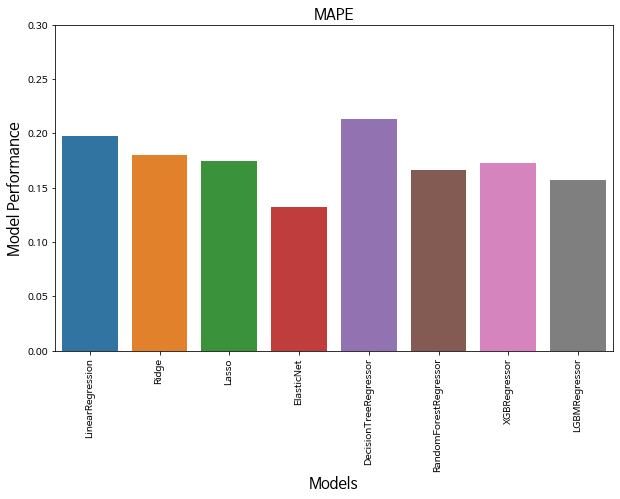

[I 2022-10-11 12:22:23,705] A new study created in memory with name: no-name-3f3b5c2e-acb7-4658-8b83-58e6dabef016


(927, 33) (927,) (232, 33) (232,)


[I 2022-10-11 12:22:24,957] Trial 0 finished with value: 0.17134699515578938 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.17134699515578938.
[I 2022-10-11 12:22:28,050] Trial 1 finished with value: 0.1713223109452337 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.1713223109452337.
[I 2022-10-11 12:22:28,158] Trial 2 finished with value: 0.1476215919070724 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.1476215919070724.
[I 2022-10-11 12:22:28,613] Trial 3 finished with value: 0.15898180289058494 and parameters: {'max_depth': 10, 'learning_rate': 0.00021405821746591817, 'n_estimat

Best Trial: score 0.13475515685754721,
params {'max_depth': 9, 'learning_rate': 0.007542960192358775, 'n_estimators': 1692, 'min_child_samples': 97, 'subsample': 0.8946645027151933}


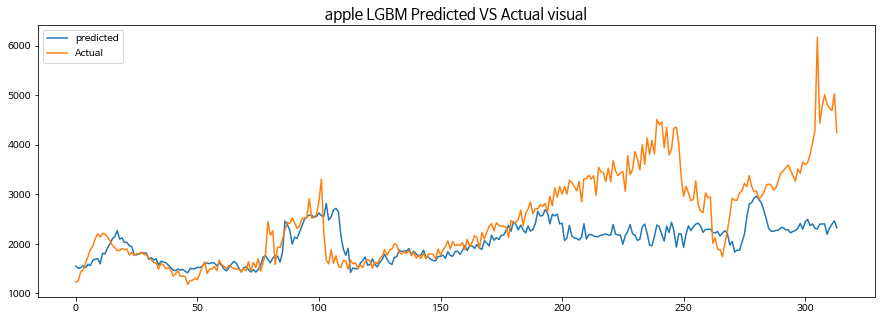

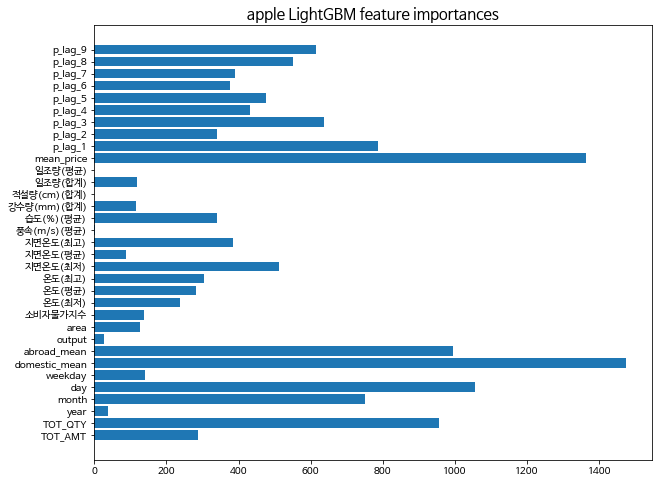

In [ ]:
# 전체 과정 돌려~

train_X, test_X, train_y, test_y = baseline_modeling(apple2)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

models = []
scores = []
# 기본 모델로
for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
    model_name, mean_score = print_mape_score(model)
    models.append(model_name)
    scores.append(mean_score)

result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
display(result_df)


f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.3)
plt.title('MAPE', fontsize=15)
plt.show()


cut = int(len(train_X)*0.8)

h_train_X = train_X[:cut]
h_train_y = train_y[:cut]

h_valid_X = train_X[cut:]
h_valid_y = train_y[cut:]

print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)


# LightGBM Optuna 사용

from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    # dtrain = LGBMRegressor.Dataset(h_train_X, label=h_train_y)
    # dtest = LGBMRegressor.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mape', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    mape = MAPE(h_valid_y, lgb_model.predict(h_valid_X))
    return mape
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_X)

# 실제값 예측값 시각화

plt.figure(figsize = (15,5))
plt.plot(final_lgb_pred, label = 'predicted')
plt.plot(np.array(test_y), label = 'Actual')
plt.legend()
plt.title('apple LGBM Predicted VS Actual visual', fontsize = 15)
plt.show()

# LightGBM feature importances 시각화

plt.figure(figsize = (10,8))
plt.barh(train_X.columns, final_lgb_model.feature_importances_)
plt.title('apple LightGBM feature importances', fontsize = 15)
plt.show()

## 외부변수 제외, 시계열 분포 feature만

In [ ]:
apple.columns

Index(['SALEDATE', 'TOT_AMT', 'TOT_QTY', 'year', 'month', 'day', 'weekday',
       'domestic_mean', 'abroad_mean', 'output', 'area', '소비자물가지수', '온도(최저)',
       '온도(평균)', '온도(최고)', '지면온도(최저)', '지면온도(평균)', '지면온도(최고)', '풍속(m/s)(평균)',
       '습도(%)(평균)', '강수량(mm)(합계)', '적설량(cm)(합계)', '일조량(합계)', '일조량(평균)',
       'mean_price'],
      dtype='object')

In [ ]:
#기본만
apple3 = apple[['SALEDATE', 'TOT_AMT','TOT_QTY', 'year', 'month', 'day', 'weekday', 'mean_price']]
apple3

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,mean_price
0,2016-01-01,100487.00,79.00,2016.00,1.00,1.00,4.00,1267.00
1,2016-01-02,302868.00,117.00,2016.00,1.00,2.00,5.00,2594.00
2,2016-01-04,311936.00,168.00,2016.00,1.00,4.00,0.00,1860.00
3,2016-01-05,265467.00,158.00,2016.00,1.00,5.00,1.00,1676.00
4,2016-01-06,273227.00,162.00,2016.00,1.00,6.00,2.00,1688.00
...,...,...,...,...,...,...,...,...
1475,2020-09-24,534041.00,111.00,2020.00,9.00,24.00,3.00,4824.00
1476,2020-09-25,519609.00,110.00,2020.00,9.00,25.00,4.00,4736.00
1477,2020-09-26,522456.00,111.00,2020.00,9.00,26.00,5.00,4689.00
1478,2020-09-27,433049.00,86.00,2020.00,9.00,27.00,6.00,5028.00


In [ ]:
#요일컬럼 추가 -> 원 핫 인코딩
def weekday(df_test):
    weekday=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    df_test['요일']=0
    for i in range(len(df_test)):
        df_test['요일'][i]=weekday[df_test['SALEDATE'][i].weekday()]
    df_test = pd.concat([df_test, pd.get_dummies(df_test['요일'])], axis=1)
    df_test =df_test.drop(columns='요일')
    return df_test


# prophet의 추세선처럼 시계열 데이터 특성 feature로 활용

#시계열 분해 잔차활용
def resid(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['resid']=date_resid.fit().resid.values
    return df

#시계열 분해 트렌드활용
def trend(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['trend']=date_resid.fit().trend.values
    return df

#시계열 분해 시즌활용
def season(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['season']=date_resid.fit().seasonal.values
    return df

In [ ]:
# 시계열 관련 feature 추가
apple3 = resid(apple3)
apple3 = trend(apple3)
apple3 = season(apple3)
apple3 = weekday(apple3)
apple3 = train_serise(apple3)

In [ ]:
apple3.columns

Index(['SALEDATE', 'TOT_AMT', 'TOT_QTY', 'year', 'month', 'day', 'weekday',
       'mean_price', 'resid', 'trend', 'season', '금요일', '목요일', '수요일', '월요일',
       '일요일', '토요일', '화요일', 'p_lag_1', 'p_lag_2', 'p_lag_3', 'p_lag_4',
       'p_lag_5', 'p_lag_6', 'p_lag_7', 'p_lag_8', 'p_lag_9'],
      dtype='object')

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,mean_price,resid,trend,...,p_lag_1,p_lag_2,p_lag_3,p_lag_4,p_lag_5,p_lag_6,p_lag_7,p_lag_8,p_lag_9,1week
0,2016-01-01,100487.00,79.00,2016.00,1.00,1.00,4.00,1267.00,-240.40,1799.52,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1644
1,2016-01-02,302868.00,117.00,2016.00,1.00,2.00,5.00,2594.00,371.17,1793.85,...,1267,-1,-1,-1,-1,-1,-1,-1,-1,1779


(1159, 26) (1159,) (314, 26) (314,)
(1159, 26) (314, 26) (1159,) (314,)


LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 169.53it/s]


1 FOLDS: LinearRegression MAPE: 0.1034
2 FOLDS: LinearRegression MAPE: 0.1740
3 FOLDS: LinearRegression MAPE: 0.1933
4 FOLDS: LinearRegression MAPE: 0.0583
5 FOLDS: LinearRegression MAPE: 0.0772
6 FOLDS: LinearRegression MAPE: 0.0586
7 FOLDS: LinearRegression MAPE: 0.0771
8 FOLDS: LinearRegression MAPE: 0.0668
9 FOLDS: LinearRegression MAPE: 0.0462
10 FOLDS: LinearRegression MAPE: 0.1280

LinearRegression mean MAPE: 0.0983


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 171.07it/s]


1 FOLDS: Ridge MAPE: 0.1023
2 FOLDS: Ridge MAPE: 0.1735
3 FOLDS: Ridge MAPE: 0.1164
4 FOLDS: Ridge MAPE: 0.0581
5 FOLDS: Ridge MAPE: 0.0769
6 FOLDS: Ridge MAPE: 0.0589
7 FOLDS: Ridge MAPE: 0.0779
8 FOLDS: Ridge MAPE: 0.0670
9 FOLDS: Ridge MAPE: 0.0462
10 FOLDS: Ridge MAPE: 0.0995

Ridge mean MAPE: 0.0877


Lasso Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 60.10it/s]


1 FOLDS: Lasso MAPE: 0.1001
2 FOLDS: Lasso MAPE: 0.1661
3 FOLDS: Lasso MAPE: 0.1459
4 FOLDS: Lasso MAPE: 0.0574
5 FOLDS: Lasso MAPE: 0.0771
6 FOLDS: Lasso MAPE: 0.0568
7 FOLDS: Lasso MAPE: 0.0782
8 FOLDS: Lasso MAPE: 0.0679
9 FOLDS: Lasso MAPE: 0.0448
10 FOLDS: Lasso MAPE: 0.1005

Lasso mean MAPE: 0.0895


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 193.57it/s]


1 FOLDS: ElasticNet MAPE: 0.1031
2 FOLDS: ElasticNet MAPE: 0.1776
3 FOLDS: ElasticNet MAPE: 0.0601
4 FOLDS: ElasticNet MAPE: 0.0896
5 FOLDS: ElasticNet MAPE: 0.1025
6 FOLDS: ElasticNet MAPE: 0.0775
7 FOLDS: ElasticNet MAPE: 0.1201
8 FOLDS: ElasticNet MAPE: 0.1141
9 FOLDS: ElasticNet MAPE: 0.0555
10 FOLDS: ElasticNet MAPE: 0.1689

ElasticNet mean MAPE: 0.1069


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 72.07it/s]


1 FOLDS: DecisionTreeRegressor MAPE: 0.1253
2 FOLDS: DecisionTreeRegressor MAPE: 0.2718
3 FOLDS: DecisionTreeRegressor MAPE: 0.2126
4 FOLDS: DecisionTreeRegressor MAPE: 0.2115
5 FOLDS: DecisionTreeRegressor MAPE: 0.1503
6 FOLDS: DecisionTreeRegressor MAPE: 0.0876
7 FOLDS: DecisionTreeRegressor MAPE: 0.1098
8 FOLDS: DecisionTreeRegressor MAPE: 0.1209
9 FOLDS: DecisionTreeRegressor MAPE: 0.1133
10 FOLDS: DecisionTreeRegressor MAPE: 0.2003

DecisionTreeRegressor mean MAPE: 0.1604


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1229
2 FOLDS: RandomForestRegressor MAPE: 0.2248
3 FOLDS: RandomForestRegressor MAPE: 0.0949
4 FOLDS: RandomForestRegressor MAPE: 0.0858
5 FOLDS: RandomForestRegressor MAPE: 0.0977
6 FOLDS: RandomForestRegressor MAPE: 0.0475
7 FOLDS: RandomForestRegressor MAPE: 0.0873
8 FOLDS: RandomForestRegressor MAPE: 0.1092
9 FOLDS: RandomForestRegressor MAPE: 0.0686
10 FOLDS: RandomForestRegressor MAPE: 0.1718

RandomForestRegressor mean MAPE: 0.1111


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 23.64it/s]

[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  60%|██████    | 6/10 [00:00<00:00, 16.00it/s]

[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  80%|████████  | 8/10 [00:00<00:00, 12.71it/s]

[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]


1 FOLDS: XGBRegressor MAPE: 0.1378
2 FOLDS: XGBRegressor MAPE: 0.3032
3 FOLDS: XGBRegressor MAPE: 0.0717
4 FOLDS: XGBRegressor MAPE: 0.1039
5 FOLDS: XGBRegressor MAPE: 0.0983
6 FOLDS: XGBRegressor MAPE: 0.0606
7 FOLDS: XGBRegressor MAPE: 0.0863
8 FOLDS: XGBRegressor MAPE: 0.0967
9 FOLDS: XGBRegressor MAPE: 0.0689
10 FOLDS: XGBRegressor MAPE: 0.1665

XGBRegressor mean MAPE: 0.1194


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1270
2 FOLDS: LGBMRegressor MAPE: 0.2743
3 FOLDS: LGBMRegressor MAPE: 0.0762
4 FOLDS: LGBMRegressor MAPE: 0.1269
5 FOLDS: LGBMRegressor MAPE: 0.0726
6 FOLDS: LGBMRegressor MAPE: 0.0614
7 FOLDS: LGBMRegressor MAPE: 0.0910
8 FOLDS: LGBMRegressor MAPE: 0.1207
9 FOLDS: LGBMRegressor MAPE: 0.0737
10 FOLDS: LGBMRegressor MAPE: 0.1609

LGBMRegressor mean MAPE: 0.1184


,Model,Score
0,LinearRegression,0.10
1,Ridge,0.09
2,Lasso,0.09
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.16
5,RandomForestRegressor,0.11
6,XGBRegressor,0.12
7,LGBMRegressor,0.12


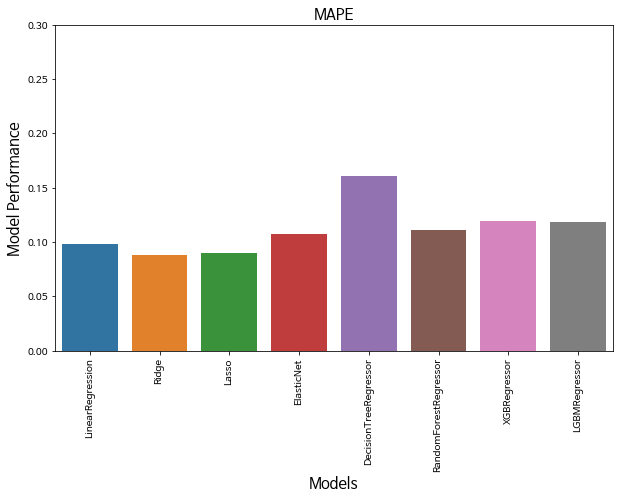

[I 2022-10-11 12:24:58,381] A new study created in memory with name: no-name-5d36242d-629a-403d-b3c6-5a3d3cf43ef0


(927, 26) (927,) (232, 26) (232,)


[I 2022-10-11 12:24:59,376] Trial 0 finished with value: 0.17134630055529654 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.17134630055529654.
[I 2022-10-11 12:25:02,127] Trial 1 finished with value: 0.17130887612139697 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.17130887612139697.
[I 2022-10-11 12:25:02,224] Trial 2 finished with value: 0.13023066833407362 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.13023066833407362.
[I 2022-10-11 12:25:02,629] Trial 3 finished with value: 0.15529422200987167 and parameters: {'max_depth': 10, 'learning_rate': 0.00021405821746591817, 'n_est

Best Trial: score 0.09878122320846158,
params {'max_depth': 3, 'learning_rate': 0.006728368653707849, 'n_estimators': 2155, 'min_child_samples': 89, 'subsample': 0.42007343169282657}


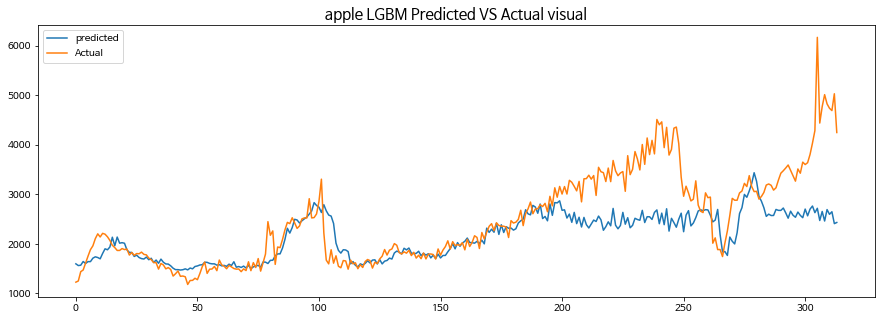

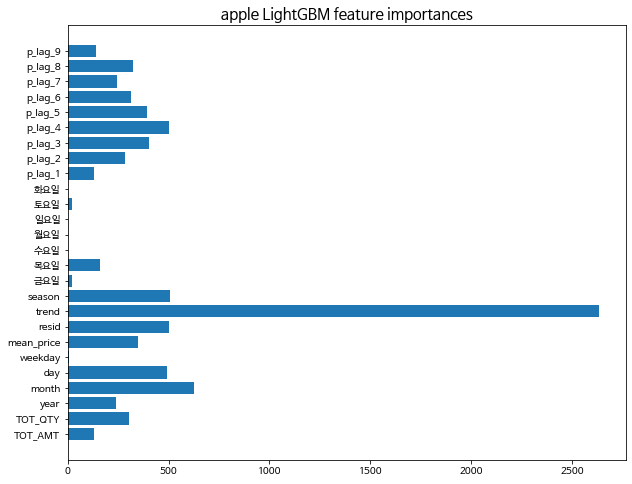

In [ ]:
# 전체 과정 돌려~

train_X, test_X, train_y, test_y = baseline_modeling(apple3)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

models = []
scores = []
# 기본 모델로
for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
    model_name, mean_score = print_mape_score(model)
    models.append(model_name)
    scores.append(mean_score)

result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
display(result_df)


f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0, 0.3)
plt.title('MAPE', fontsize=15)
plt.show()


cut = int(len(train_X)*0.8)

h_train_X = train_X[:cut]
h_train_y = train_y[:cut]

h_valid_X = train_X[cut:]
h_valid_y = train_y[cut:]

print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)


# LightGBM Optuna 사용

from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    # dtrain = LGBMRegressor.Dataset(h_train_X, label=h_train_y)
    # dtest = LGBMRegressor.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mape', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    mape = MAPE(h_valid_y, lgb_model.predict(h_valid_X))
    return mape
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_X)

# 실제값 예측값 시각화

plt.figure(figsize = (15,5))
plt.plot(final_lgb_pred, label = 'predicted')
plt.plot(np.array(test_y), label = 'Actual')
plt.legend()
plt.title('apple LGBM Predicted VS Actual visual', fontsize = 15)
plt.show()

# LightGBM feature importances 시각화

plt.figure(figsize = (10,8))
plt.barh(train_X.columns, final_lgb_model.feature_importances_)
plt.title('apple LightGBM feature importances', fontsize = 15)
plt.show()

In [ ]:
# trend선이 가장 높게 나옴
apple3[['trend', 'mean_price']]

,trend,mean_price
0,1799.52,1267.00
1,1793.85,2594.00
2,1789.49,1860.00
3,1786.66,1676.00
4,1785.50,1688.00
...,...,...
1475,4840.55,4824.00
1476,4943.74,4736.00
1477,5046.02,4689.00
1478,5147.15,5028.00


### 찬샘님 hyper-parameter 사용

In [ ]:
# 찬샘님 hyper-parameter 사용

def modeling(x_train,y_train,x_test):
     #lightGBM모델
     lgbm_reg = LGBMRegressor(
     num_leaves=100,
     max_depth=30,
     metric='mape',
     learning_rate=0.01,
     n_estimators=700,
     min_data_in_leaf = 55,
     max_bin = 159,
     )
     lgbm_reg.fit(x_train, y_train)
     lgbm_pred = lgbm_reg.predict(x_test)

     #XGBoost 모델
     xgb_reg=XGBRegressor(
          learning_rate = 0.01,
          max_depth = 11,
          n_estimators = 550,
     )
     xgb_reg.fit(x_train,y_train)
     xgb_pred = xgb_reg.predict(x_test)

     #randomforest 모델
     rf_reg =RandomForestRegressor(
          n_estimators = 355,
          max_depth = 10,
     )
     rf_reg.fit(x_train,y_train)
     rf_pred = rf_reg.predict(x_test)

     return lgbm_pred, xgb_pred, rf_pred

In [ ]:
lgbm_pred, xgb_pred, rf_pred = modeling(train_X, train_y, test_X)

[12:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
mape2 = mean_absolute_percentage_error(test_y, lgbm_pred)
print('lgbm mape:', mape2)
mape2 = mean_absolute_percentage_error(test_y, xgb_pred)
print('xgb mape:', mape2)
mape2 = mean_absolute_percentage_error(test_y, rf_pred)
print('rf mape:', mape2)

lgbm mape: 0.14267366249399396
xgb mape: 0.1424459616980059
rf mape: 0.13436710077797373


## Prophet 모델 사용

In [ ]:
apple4 = apple[['SALEDATE', 'mean_price']]
apple4 = apple4.rename(columns = {'SALEDATE' : 'ds', 'mean_price' : 'y'})
apple4

In [ ]:
train = apple4[apple.SALEDATE < '2019-09-22']
test = apple4[apple.SALEDATE >= '2019-09-22']
test.shape

(321, 2)

Prophet model parameter 기본값

```
prophet = Prophet(daily_seasonality=False,
                  growth='linear',
                  changepoints=auto, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality=auto, 
                  weekly_seasonality=True, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000)

```


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/2n4p282b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/cj4k8jay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82463', 'data', 'file=/tmp/tmpxyhpv5zm/2n4p282b.json', 'init=/tmp/tmpxyhpv5zm/cj4k8jay.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeleszg5t1s/prophet_model-20221011115257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


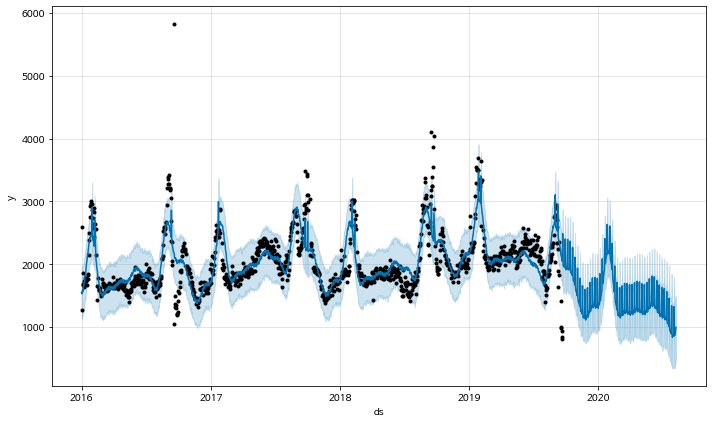

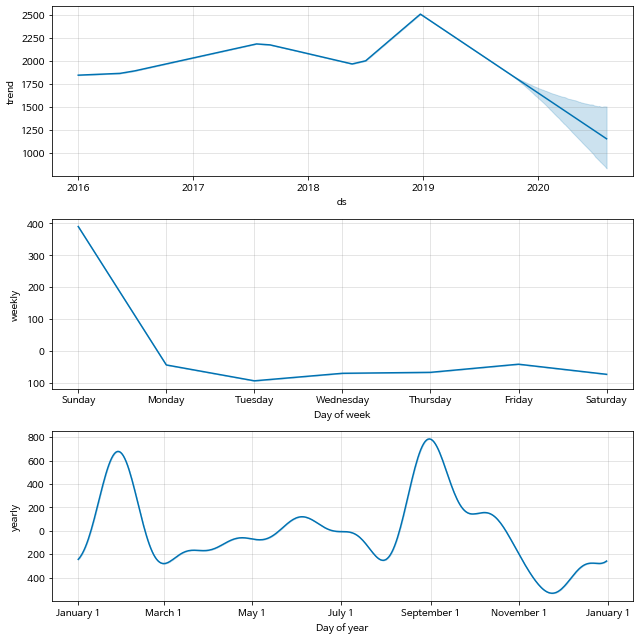

321 321
mean_absolute_percentage_error Error: 0.403


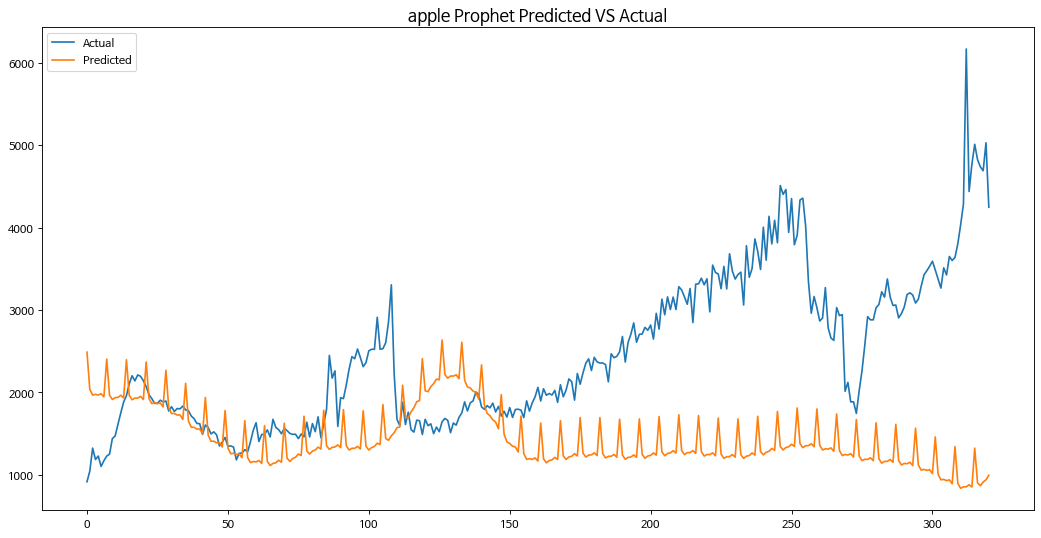

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

prophet = Prophet() # default model
prophet.fit(train)
future = prophet.make_future_dataframe(periods=test.shape[0]) # test1.shape = (232, 2)
forecast_tr = prophet.predict(future)
prophet.plot(forecast_tr)
plt.show()

prophet.plot_components(forecast_tr)
plt.show()


y_true= test['y'].values
y_pred = forecast_tr['yhat'][-len(y_true):].values
print(len(y_true), len(y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print('mean_absolute_percentage_error Error: %.3f' % mape)

#  Predicted vs Actual
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(test['y'].values, label='Actual')
plt.plot(forecast_tr['yhat'].values[-test.shape[0]:], label='Predicted')
plt.legend()
plt.title('apple Prophet Predicted VS Actual', fontsize = 15)
plt.show()

### Prophet hyper-parameter

- Prophet에는 내장된 기능이 있어서 NaN을 유지하는 것을 선호함 (prophet에는 결측값을 처리하는 방법이 있음)

In [ ]:
# 이상치 제거

Q1=train.y.quantile(0.25)
Q3=train.y.quantile(0.75)
IQR = Q3 - Q1
LT=Q1-1.5*IQR # 임계값
HT= Q3+1.5*IQR # 임계값
print(LT, HT)
train['outlier']=np.where(((train['y']<LT)|(train['y']>HT)),'yes','no')
train.loc[(train['outlier']=='yes'), 'y'] = None # 이상치는 None으로, prophet은 이상치는 
train.head()

945.0 3021.0


,ds,y,outlier
0,2016-01-01,1267.00,no
1,2016-01-02,2594.00,no
2,2016-01-04,1860.00,no
3,2016-01-05,1676.00,no
4,2016-01-06,1688.00,no


In [ ]:
# 휴일 추가
import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.Korea(years=[2016, 2017, 2018, 2019, 2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "KR-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday = holiday[holiday.ds < '2020-09-30']
holiday.tail()

,ds,holiday
75,2020-05-01,KR-Holidays
76,2020-05-05,KR-Holidays
77,2020-06-06,KR-Holidays
78,2020-08-15,KR-Holidays
79,2020-08-17,KR-Holidays


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/f31k8nhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/zr48vegn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72050', 'data', 'file=/tmp/tmpxyhpv5zm/f31k8nhx.json', 'init=/tmp/tmpxyhpv5zm/zr48vegn.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelxf8a5k6j/prophet_model-20221011115239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


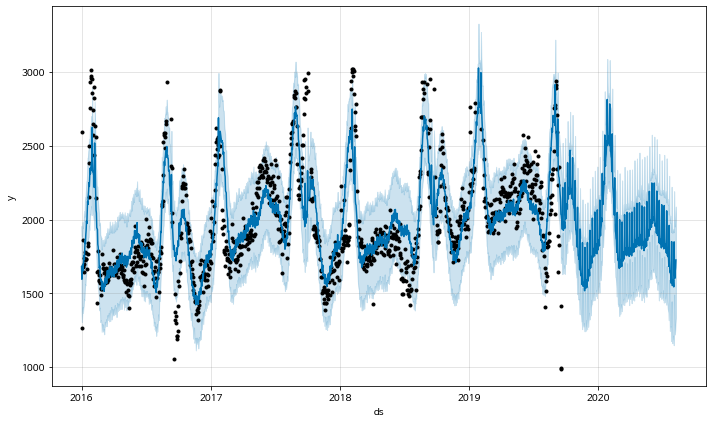

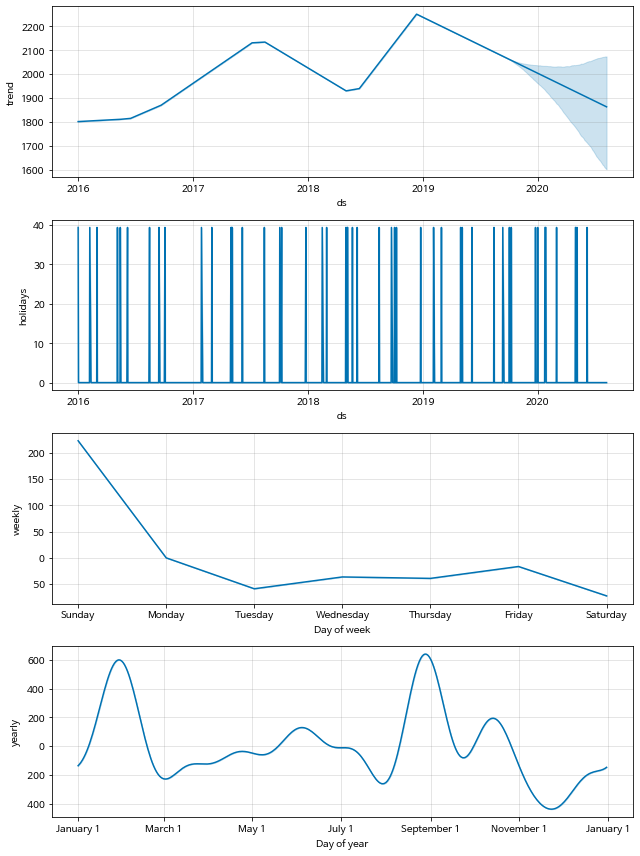

321 321
mean_absolute_percentage_error Error: 0.314


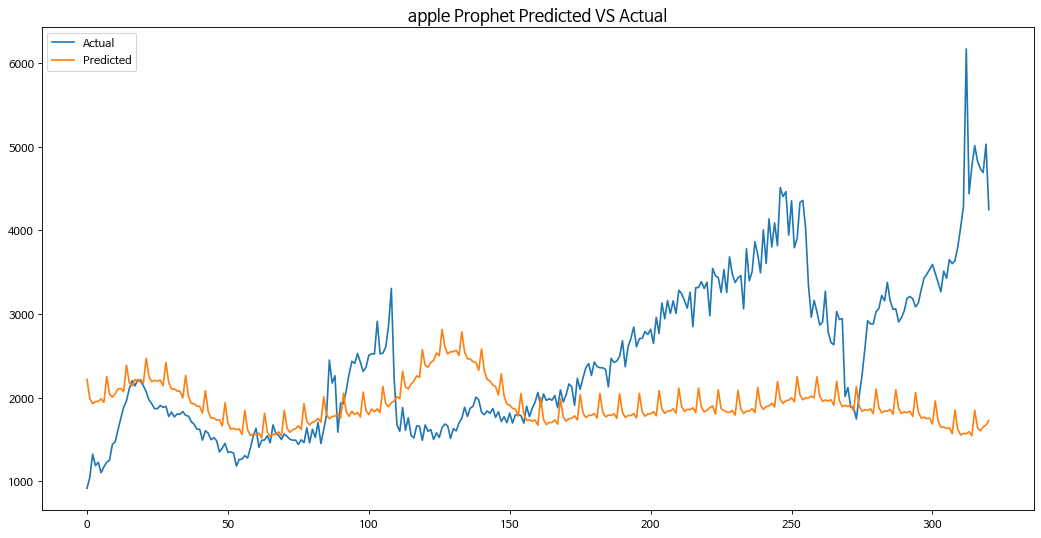

In [ ]:
prophet = Prophet(holidays = holiday) # default model
prophet.fit(train)
future = prophet.make_future_dataframe(periods = test.shape[0]) 
forecast_tr = prophet.predict(future)
prophet.plot(forecast_tr)
plt.show()

prophet.plot_components(forecast_tr)
plt.show()


y_true= test['y'].values
y_pred = forecast_tr['yhat'][-len(y_true):].values
print(len(y_true), len(y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print('mean_absolute_percentage_error Error: %.3f' % mape)

#  Predicted vs Actual
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(test['y'].values, label='Actual')
plt.plot(forecast_tr['yhat'].values[-test.shape[0]:], label='Predicted')
plt.legend()
plt.title('apple Prophet Predicted VS Actual', fontsize = 15)
plt.show()

Prophet hyper-parameter tuning

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {
              'seasonality_mode':('multiplicative','additive'),
              'seasonality_prior_scale' : [5, 10, 15], # default : 10
              'changepoint_prior_scale':[0.01,0.03,0.05,0.1,0.2], # default : 0.05
              'holidays_prior_scale':[1, 5, 10 ,15], # default : 10
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 120


In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    LOL = pd.DataFrame()
    print(p)
#    random.seed(0)

    train_model =Prophet(
                         changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         seasonality_mode = p['seasonality_mode'],
                         n_changepoints = 25,
                         weekly_seasonality= 'auto',
                         daily_seasonality = 'auto',
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.8)
    train_model.add_country_holidays(country_name='KR')
    train_model.fit(train)
    future = train_model.make_future_dataframe(periods=test.shape[0])
    train_forecast = train_model.predict(future)
    LOL=train_forecast[['ds','yhat']]
    y_true= test['y'].values
    y_pred = LOL['yhat'][:len(y_true)].values
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('mean_absolute_percentage_error Error: %.3f' % mape)
    model_parameters = model_parameters.append({'MAPE':mape,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/_9labofc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ygq5u1_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31180', 'data', 'file=/tmp/tmpxyhpv5zm/_9labofc.json', 'init=/tmp/tmpxyhpv5zm/ygq5u1_3.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelwdjwkhxm/prophet_model-20221011120534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/9n56q3h8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/nf93qzwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86104', 'data', 'file=/tmp/tmpxyhpv5zm/9n56q3h8.json', 'init=/tmp/tmpxyhpv5zm/nf93qzwv.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model6xsgs3i6/prophet_model-20221011120536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/bdq5b7ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/d874ps_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76254', 'data', 'file=/tmp/tmpxyhpv5zm/bdq5b7ni.json', 'init=/tmp/tmpxyhpv5zm/d874ps_0.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelu8v8rdek/prophet_model-20221011120539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/n574iaof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/bfpe2n1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13639', 'data', 'file=/tmp/tmpxyhpv5zm/n574iaof.json', 'init=/tmp/tmpxyhpv5zm/bfpe2n1o.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeligd2kna8/prophet_model-20221011120541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/z6ljliyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/r74ervbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13', 'data', 'file=/tmp/tmpxyhpv5zm/z6ljliyy.json', 'init=/tmp/tmpxyhpv5zm/r74ervbl.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0925gx6r/prophet_model-20221011120543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/_lxeeb9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/pfkqn1lv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53098', 'data', 'file=/tmp/tmpxyhpv5zm/_lxeeb9x.json', 'init=/tmp/tmpxyhpv5zm/pfkqn1lv.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0xm8va_5/prophet_model-20221011120545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/nyjvz_oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/xr9krb7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56071', 'data', 'file=/tmp/tmpxyhpv5zm/nyjvz_oa.json', 'init=/tmp/tmpxyhpv5zm/xr9krb7l.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0lliyxrx/prophet_model-20221011120547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.271
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/aw6tir03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gfvtd0zi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99291', 'data', 'file=/tmp/tmpxyhpv5zm/aw6tir03.json', 'init=/tmp/tmpxyhpv5zm/gfvtd0zi.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelppckey67/prophet_model-20221011120549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/im682v4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ikm4sd_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10113', 'data', 'file=/tmp/tmpxyhpv5zm/im682v4g.json', 'init=/tmp/tmpxyhpv5zm/ikm4sd_s.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeldqc4z0g1/prophet_model-20221011120552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3n0h45my.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/jhlsm6bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66817', 'data', 'file=/tmp/tmpxyhpv5zm/3n0h45my.json', 'init=/tmp/tmpxyhpv5zm/jhlsm6bz.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelopu0s7tg/prophet_model-20221011120554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5fyeljoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4z_01c3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66469', 'data', 'file=/tmp/tmpxyhpv5zm/5fyeljoc.json', 'init=/tmp/tmpxyhpv5zm/4z_01c3r.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model9k5rqwqc/prophet_model-20221011120556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/dkvxniex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7ydcxuax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29870', 'data', 'file=/tmp/tmpxyhpv5zm/dkvxniex.json', 'init=/tmp/tmpxyhpv5zm/7ydcxuax.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelyvuefuva/prophet_model-20221011120558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/1d8vk910.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/6mkqra0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99234', 'data', 'file=/tmp/tmpxyhpv5zm/1d8vk910.json', 'init=/tmp/tmpxyhpv5zm/6mkqra0r.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelpi1_apmk/prophet_model-20221011120600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.271
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/vzuxfk43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/d0w1831n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42225', 'data', 'file=/tmp/tmpxyhpv5zm/vzuxfk43.json', 'init=/tmp/tmpxyhpv5zm/d0w1831n.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_models7dfw86w/prophet_model-20221011120602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/vflphdqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/qy6516f4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83481', 'data', 'file=/tmp/tmpxyhpv5zm/vflphdqf.json', 'init=/tmp/tmpxyhpv5zm/qy6516f4.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model2kt_q8_b/prophet_model-20221011120605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/zb61xlfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/biztl3l0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60098', 'data', 'file=/tmp/tmpxyhpv5zm/zb61xlfw.json', 'init=/tmp/tmpxyhpv5zm/biztl3l0.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelpjh5tofv/prophet_model-20221011120607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5xsg4taj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/fncghxzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53159', 'data', 'file=/tmp/tmpxyhpv5zm/5xsg4taj.json', 'init=/tmp/tmpxyhpv5zm/fncghxzn.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0rtm15x_/prophet_model-20221011120609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/kfulrnny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4ato9y3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83952', 'data', 'file=/tmp/tmpxyhpv5zm/kfulrnny.json', 'init=/tmp/tmpxyhpv5zm/4ato9y3x.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelu2g1mt2t/prophet_model-20221011120611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/bandwnn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/o91i4kp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40912', 'data', 'file=/tmp/tmpxyhpv5zm/bandwnn8.json', 'init=/tmp/tmpxyhpv5zm/o91i4kp0.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeluidapwsc/prophet_model-20221011120613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ot6ri9oy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/rcfepzbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63799', 'data', 'file=/tmp/tmpxyhpv5zm/ot6ri9oy.json', 'init=/tmp/tmpxyhpv5zm/rcfepzbg.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelxremkcfe/prophet_model-20221011120615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.271
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/a53cix2h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/btlkawex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60909', 'data', 'file=/tmp/tmpxyhpv5zm/a53cix2h.json', 'init=/tmp/tmpxyhpv5zm/btlkawex.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelb232q7gu/prophet_model-20221011120618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/zmrfe40s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/rlm10qrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87090', 'data', 'file=/tmp/tmpxyhpv5zm/zmrfe40s.json', 'init=/tmp/tmpxyhpv5zm/rlm10qrw.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelbzfzq0z4/prophet_model-20221011120620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/z7obaek9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/149wv62e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80839', 'data', 'file=/tmp/tmpxyhpv5zm/z7obaek9.json', 'init=/tmp/tmpxyhpv5zm/149wv62e.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelej9sriys/prophet_model-20221011120622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ucvhyfjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4ex0333v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21251', 'data', 'file=/tmp/tmpxyhpv5zm/ucvhyfjo.json', 'init=/tmp/tmpxyhpv5zm/4ex0333v.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelb3x7_iol/prophet_model-20221011120624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/6nhu73o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ivid02og.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4478', 'data', 'file=/tmp/tmpxyhpv5zm/6nhu73o5.json', 'init=/tmp/tmpxyhpv5zm/ivid02og.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeleg1owuky/prophet_model-20221011120626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0ol5p8ki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/lmme2n0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27186', 'data', 'file=/tmp/tmpxyhpv5zm/0ol5p8ki.json', 'init=/tmp/tmpxyhpv5zm/lmme2n0c.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeljnms36wa/prophet_model-20221011120628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/n6krpkar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/c3x6k63x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61266', 'data', 'file=/tmp/tmpxyhpv5zm/n6krpkar.json', 'init=/tmp/tmpxyhpv5zm/c3x6k63x.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelxqj07nyk/prophet_model-20221011120631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/l42aesqi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/qxe4uk_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40407', 'data', 'file=/tmp/tmpxyhpv5zm/l42aesqi.json', 'init=/tmp/tmpxyhpv5zm/qxe4uk_p.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model2mcbix0k/prophet_model-20221011120633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/y951dtsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/14qvjevo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71229', 'data', 'file=/tmp/tmpxyhpv5zm/y951dtsf.json', 'init=/tmp/tmpxyhpv5zm/14qvjevo.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modely2kcys7g/prophet_model-20221011120635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gp6io73u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ytfs6e9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24572', 'data', 'file=/tmp/tmpxyhpv5zm/gp6io73u.json', 'init=/tmp/tmpxyhpv5zm/ytfs6e9z.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelgec5apmv/prophet_model-20221011120638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/unr9z7nw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/dyyx60ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16148', 'data', 'file=/tmp/tmpxyhpv5zm/unr9z7nw.json', 'init=/tmp/tmpxyhpv5zm/dyyx60ju.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelisnnjyhz/prophet_model-20221011120640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/s2rwxjob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7g320ktx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22333', 'data', 'file=/tmp/tmpxyhpv5zm/s2rwxjob.json', 'init=/tmp/tmpxyhpv5zm/7g320ktx.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelw58zjndr/prophet_model-20221011120642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/xt07pa8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/_yjkjk1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12890', 'data', 'file=/tmp/tmpxyhpv5zm/xt07pa8j.json', 'init=/tmp/tmpxyhpv5zm/_yjkjk1i.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelwjoo6e_p/prophet_model-20221011120645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gtxg5cda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0vxm1okf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3061', 'data', 'file=/tmp/tmpxyhpv5zm/gtxg5cda.json', 'init=/tmp/tmpxyhpv5zm/0vxm1okf.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model2ei7gyox/prophet_model-20221011120647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/t2ryhiap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3jx1_m17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21690', 'data', 'file=/tmp/tmpxyhpv5zm/t2ryhiap.json', 'init=/tmp/tmpxyhpv5zm/3jx1_m17.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0kodvffp/prophet_model-20221011120649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/uw9832i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/22m4kyy8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5766', 'data', 'file=/tmp/tmpxyhpv5zm/uw9832i2.json', 'init=/tmp/tmpxyhpv5zm/22m4kyy8.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model9jla6sl1/prophet_model-20221011120652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/wju7wzq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/tceb_y31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33405', 'data', 'file=/tmp/tmpxyhpv5zm/wju7wzq6.json', 'init=/tmp/tmpxyhpv5zm/tceb_y31.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model749am4h9/prophet_model-20221011120654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/qpgprm8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/tu2qcb6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41311', 'data', 'file=/tmp/tmpxyhpv5zm/qpgprm8b.json', 'init=/tmp/tmpxyhpv5zm/tu2qcb6x.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelhoo8ne8c/prophet_model-20221011120656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/1r524b4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/wcbnh0kv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95708', 'data', 'file=/tmp/tmpxyhpv5zm/1r524b4g.json', 'init=/tmp/tmpxyhpv5zm/wcbnh0kv.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelcci9bni2/prophet_model-20221011120658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/6cmxwhev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/l3tcxuyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27930', 'data', 'file=/tmp/tmpxyhpv5zm/6cmxwhev.json', 'init=/tmp/tmpxyhpv5zm/l3tcxuyp.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model1okjd6w9/prophet_model-20221011120701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/fb53yy_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/tngm019o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13537', 'data', 'file=/tmp/tmpxyhpv5zm/fb53yy_9.json', 'init=/tmp/tmpxyhpv5zm/tngm019o.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model40wlthz_/prophet_model-20221011120703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/to1xkw8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5zy1plz4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98358', 'data', 'file=/tmp/tmpxyhpv5zm/to1xkw8m.json', 'init=/tmp/tmpxyhpv5zm/5zy1plz4.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeldzdab3uc/prophet_model-20221011120705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/082con5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/fwy096w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25683', 'data', 'file=/tmp/tmpxyhpv5zm/082con5n.json', 'init=/tmp/tmpxyhpv5zm/fwy096w7.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeln8c1e16_/prophet_model-20221011120708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/abdrwuza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/2yh5tcfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63073', 'data', 'file=/tmp/tmpxyhpv5zm/abdrwuza.json', 'init=/tmp/tmpxyhpv5zm/2yh5tcfa.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelct5soked/prophet_model-20221011120710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/o0gvygv6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/rvy34is2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11718', 'data', 'file=/tmp/tmpxyhpv5zm/o0gvygv6.json', 'init=/tmp/tmpxyhpv5zm/rvy34is2.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelsrvcmvtf/prophet_model-20221011120712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/m27ky34i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/vqrugtyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52685', 'data', 'file=/tmp/tmpxyhpv5zm/m27ky34i.json', 'init=/tmp/tmpxyhpv5zm/vqrugtyu.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelx0ouu0tu/prophet_model-20221011120714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.261
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ceczysyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/whhy50eg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14915', 'data', 'file=/tmp/tmpxyhpv5zm/ceczysyt.json', 'init=/tmp/tmpxyhpv5zm/whhy50eg.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeld_2rgkk7/prophet_model-20221011120717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/8db_yrg6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/mz0l6uan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68482', 'data', 'file=/tmp/tmpxyhpv5zm/8db_yrg6.json', 'init=/tmp/tmpxyhpv5zm/mz0l6uan.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelyegkghz2/prophet_model-20221011120719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.260
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/89jhkvd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ku6gw8g8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=117', 'data', 'file=/tmp/tmpxyhpv5zm/89jhkvd1.json', 'init=/tmp/tmpxyhpv5zm/ku6gw8g8.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeldhgmbnxl/prophet_model-20221011120721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/cnuortuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/n_wmco8z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74913', 'data', 'file=/tmp/tmpxyhpv5zm/cnuortuw.json', 'init=/tmp/tmpxyhpv5zm/n_wmco8z.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model1sbqt8fe/prophet_model-20221011120724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.266
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/jx8ucat1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/i2u9rvzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=897', 'data', 'file=/tmp/tmpxyhpv5zm/jx8ucat1.json', 'init=/tmp/tmpxyhpv5zm/i2u9rvzf.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0c5b5vmi/prophet_model-20221011120726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/1wkknje3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/hc43n09g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31253', 'data', 'file=/tmp/tmpxyhpv5zm/1wkknje3.json', 'init=/tmp/tmpxyhpv5zm/hc43n09g.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model18eitblx/prophet_model-20221011120728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3vk8lysn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/b6ynlqnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5027', 'data', 'file=/tmp/tmpxyhpv5zm/3vk8lysn.json', 'init=/tmp/tmpxyhpv5zm/b6ynlqnu.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeldq5cv3er/prophet_model-20221011120731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/cg37_gz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/1szq0vey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83109', 'data', 'file=/tmp/tmpxyhpv5zm/cg37_gz4.json', 'init=/tmp/tmpxyhpv5zm/1szq0vey.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model3oz6euu9/prophet_model-20221011120733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/br6m5by1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/m8kva7xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62561', 'data', 'file=/tmp/tmpxyhpv5zm/br6m5by1.json', 'init=/tmp/tmpxyhpv5zm/m8kva7xl.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model4zkieghw/prophet_model-20221011120735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gfw6typr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/lm13f2j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58503', 'data', 'file=/tmp/tmpxyhpv5zm/gfw6typr.json', 'init=/tmp/tmpxyhpv5zm/lm13f2j4.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model_ah_3ubz/prophet_model-20221011120738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/87c6a33l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/kfclb71g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16034', 'data', 'file=/tmp/tmpxyhpv5zm/87c6a33l.json', 'init=/tmp/tmpxyhpv5zm/kfclb71g.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelcu0en91l/prophet_model-20221011120740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4t6ma3d5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/zdkp21qu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51997', 'data', 'file=/tmp/tmpxyhpv5zm/4t6ma3d5.json', 'init=/tmp/tmpxyhpv5zm/zdkp21qu.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelrvljvltw/prophet_model-20221011120742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/dfgv0ogj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/tp0i4eyl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2467', 'data', 'file=/tmp/tmpxyhpv5zm/dfgv0ogj.json', 'init=/tmp/tmpxyhpv5zm/tp0i4eyl.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model64guqoif/prophet_model-20221011120744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/9h4s0dur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/oz57aac4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65486', 'data', 'file=/tmp/tmpxyhpv5zm/9h4s0dur.json', 'init=/tmp/tmpxyhpv5zm/oz57aac4.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelagf5e9do/prophet_model-20221011120747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/l5lfq3p9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/cx9wvt14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94368', 'data', 'file=/tmp/tmpxyhpv5zm/l5lfq3p9.json', 'init=/tmp/tmpxyhpv5zm/cx9wvt14.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelbhh2jbnu/prophet_model-20221011120749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/s4fqzp__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/fch2o1_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46805', 'data', 'file=/tmp/tmpxyhpv5zm/s4fqzp__.json', 'init=/tmp/tmpxyhpv5zm/fch2o1_w.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelqnf4itrx/prophet_model-20221011120751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/hg0gcmp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/p4occaez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39299', 'data', 'file=/tmp/tmpxyhpv5zm/hg0gcmp9.json', 'init=/tmp/tmpxyhpv5zm/p4occaez.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model4j9d_z9u/prophet_model-20221011120754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/uap2vknd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/pxc5cw7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83616', 'data', 'file=/tmp/tmpxyhpv5zm/uap2vknd.json', 'init=/tmp/tmpxyhpv5zm/pxc5cw7n.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelkm2bnmke/prophet_model-20221011120756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/65sbj7co.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7gsj2e_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45193', 'data', 'file=/tmp/tmpxyhpv5zm/65sbj7co.json', 'init=/tmp/tmpxyhpv5zm/7gsj2e_j.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelbhslathd/prophet_model-20221011120758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3zckg46r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ed5k2iyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4558', 'data', 'file=/tmp/tmpxyhpv5zm/3zckg46r.json', 'init=/tmp/tmpxyhpv5zm/ed5k2iyq.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model2_d0kgsj/prophet_model-20221011120801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/b0pq2xw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/jsexjqs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37672', 'data', 'file=/tmp/tmpxyhpv5zm/b0pq2xw8.json', 'init=/tmp/tmpxyhpv5zm/jsexjqs3.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model1qbadlrp/prophet_model-20221011120803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/h8dgd2ky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/scxytjdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25122', 'data', 'file=/tmp/tmpxyhpv5zm/h8dgd2ky.json', 'init=/tmp/tmpxyhpv5zm/scxytjdq.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeldg8vcarr/prophet_model-20221011120805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.266
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/l0s0o9q9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0yxpmqfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34161', 'data', 'file=/tmp/tmpxyhpv5zm/l0s0o9q9.json', 'init=/tmp/tmpxyhpv5zm/0yxpmqfj.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelev8hjysj/prophet_model-20221011120808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/kfkf3ou9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/kjn18zyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78567', 'data', 'file=/tmp/tmpxyhpv5zm/kfkf3ou9.json', 'init=/tmp/tmpxyhpv5zm/kjn18zyy.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelrctwuly5/prophet_model-20221011120810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.265
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/zinf5ig9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/pxhlj9l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32996', 'data', 'file=/tmp/tmpxyhpv5zm/zinf5ig9.json', 'init=/tmp/tmpxyhpv5zm/pxhlj9l3.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeljgk00saz/prophet_model-20221011120812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/anzy74fr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0spvd6kc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85201', 'data', 'file=/tmp/tmpxyhpv5zm/anzy74fr.json', 'init=/tmp/tmpxyhpv5zm/0spvd6kc.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelg1ozauo1/prophet_model-20221011120815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.264
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/na_85cj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ikw40gz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91651', 'data', 'file=/tmp/tmpxyhpv5zm/na_85cj6.json', 'init=/tmp/tmpxyhpv5zm/ikw40gz0.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model8k26mwwi/prophet_model-20221011120817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/bnigmqfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/94ksml6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16570', 'data', 'file=/tmp/tmpxyhpv5zm/bnigmqfb.json', 'init=/tmp/tmpxyhpv5zm/94ksml6h.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model76awqzoy/prophet_model-20221011120819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/dv863ead.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/l7861n_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10046', 'data', 'file=/tmp/tmpxyhpv5zm/dv863ead.json', 'init=/tmp/tmpxyhpv5zm/l7861n_l.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelyve45j2u/prophet_model-20221011120822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/rru6upf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/l7kmmbcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86433', 'data', 'file=/tmp/tmpxyhpv5zm/rru6upf0.json', 'init=/tmp/tmpxyhpv5zm/l7kmmbcq.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelbtnqeieh/prophet_model-20221011120824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0qsl75_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/mk0cd29d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81794', 'data', 'file=/tmp/tmpxyhpv5zm/0qsl75_f.json', 'init=/tmp/tmpxyhpv5zm/mk0cd29d.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0cza79m7/prophet_model-20221011120827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7cg78c1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/dy_vr82e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65319', 'data', 'file=/tmp/tmpxyhpv5zm/7cg78c1e.json', 'init=/tmp/tmpxyhpv5zm/dy_vr82e.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeldddfohnh/prophet_model-20221011120829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/vv9zfeea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/mw6t1rlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5736', 'data', 'file=/tmp/tmpxyhpv5zm/vv9zfeea.json', 'init=/tmp/tmpxyhpv5zm/mw6t1rlj.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelu2ayfgoe/prophet_model-20221011120832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gq5jpny3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/u0f56uc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59453', 'data', 'file=/tmp/tmpxyhpv5zm/gq5jpny3.json', 'init=/tmp/tmpxyhpv5zm/u0f56uc2.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model9w4svhjr/prophet_model-20221011120834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/z_tuylkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/hbvb2msh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89960', 'data', 'file=/tmp/tmpxyhpv5zm/z_tuylkv.json', 'init=/tmp/tmpxyhpv5zm/hbvb2msh.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelz17s76nk/prophet_model-20221011120837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/tkx3edl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/_rhw2dqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21785', 'data', 'file=/tmp/tmpxyhpv5zm/tkx3edl3.json', 'init=/tmp/tmpxyhpv5zm/_rhw2dqb.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model10iwd1ix/prophet_model-20221011120839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gabwp5wm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5zwzj38f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8830', 'data', 'file=/tmp/tmpxyhpv5zm/gabwp5wm.json', 'init=/tmp/tmpxyhpv5zm/5zwzj38f.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modely2zo01r2/prophet_model-20221011120842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/988_ybl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ooecqnya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21429', 'data', 'file=/tmp/tmpxyhpv5zm/988_ybl8.json', 'init=/tmp/tmpxyhpv5zm/ooecqnya.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelhu3kz97l/prophet_model-20221011120844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ro3w3zlg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4w44stoi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46018', 'data', 'file=/tmp/tmpxyhpv5zm/ro3w3zlg.json', 'init=/tmp/tmpxyhpv5zm/4w44stoi.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelh5lx5zgm/prophet_model-20221011120846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/xvicv0l9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/xedy7e4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71785', 'data', 'file=/tmp/tmpxyhpv5zm/xvicv0l9.json', 'init=/tmp/tmpxyhpv5zm/xedy7e4e.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelxvku1f89/prophet_model-20221011120849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/t4ofxcwe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/g_zpk32k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30561', 'data', 'file=/tmp/tmpxyhpv5zm/t4ofxcwe.json', 'init=/tmp/tmpxyhpv5zm/g_zpk32k.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0u4yb1m7/prophet_model-20221011120851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3xiyqm3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/6af8jil8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14278', 'data', 'file=/tmp/tmpxyhpv5zm/3xiyqm3y.json', 'init=/tmp/tmpxyhpv5zm/6af8jil8.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelsu2aoboh/prophet_model-20221011120854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ctw9nihn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/1s4evts6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64214', 'data', 'file=/tmp/tmpxyhpv5zm/ctw9nihn.json', 'init=/tmp/tmpxyhpv5zm/1s4evts6.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelex5yk786/prophet_model-20221011120856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7vxhsepc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/asr0lk3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=556', 'data', 'file=/tmp/tmpxyhpv5zm/7vxhsepc.json', 'init=/tmp/tmpxyhpv5zm/asr0lk3m.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelvjhrj56v/prophet_model-20221011120859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/g59td41u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/aaftgiq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33608', 'data', 'file=/tmp/tmpxyhpv5zm/g59td41u.json', 'init=/tmp/tmpxyhpv5zm/aaftgiq7.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelz9mm11yt/prophet_model-20221011120901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/knl85wuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/d2yf_f7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4617', 'data', 'file=/tmp/tmpxyhpv5zm/knl85wuq.json', 'init=/tmp/tmpxyhpv5zm/d2yf_f7m.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeljxh3jb3x/prophet_model-20221011120904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/767s_412.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/p6naw3s1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58152', 'data', 'file=/tmp/tmpxyhpv5zm/767s_412.json', 'init=/tmp/tmpxyhpv5zm/p6naw3s1.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelzhxx6739/prophet_model-20221011120906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/9yg3gc5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/8r4w8zpc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99570', 'data', 'file=/tmp/tmpxyhpv5zm/9yg3gc5b.json', 'init=/tmp/tmpxyhpv5zm/8r4w8zpc.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model1nzoasr0/prophet_model-20221011120908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/cjf0depk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/qsbfr2xc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97898', 'data', 'file=/tmp/tmpxyhpv5zm/cjf0depk.json', 'init=/tmp/tmpxyhpv5zm/qsbfr2xc.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelrns0_i9k/prophet_model-20221011120911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7b0h1pva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/iu3vk1yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78820', 'data', 'file=/tmp/tmpxyhpv5zm/7b0h1pva.json', 'init=/tmp/tmpxyhpv5zm/iu3vk1yn.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelncrpzzjd/prophet_model-20221011120913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/h181m1ik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5vmrcrnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74578', 'data', 'file=/tmp/tmpxyhpv5zm/h181m1ik.json', 'init=/tmp/tmpxyhpv5zm/5vmrcrnk.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modele0tkigzh/prophet_model-20221011120916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.268
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3mxkmnoe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/xc6v9m_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74822', 'data', 'file=/tmp/tmpxyhpv5zm/3mxkmnoe.json', 'init=/tmp/tmpxyhpv5zm/xc6v9m_n.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model1v694kj0/prophet_model-20221011120918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/cm0rd5c5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0bukv1zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92242', 'data', 'file=/tmp/tmpxyhpv5zm/cm0rd5c5.json', 'init=/tmp/tmpxyhpv5zm/0bukv1zs.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelahrmcpdo/prophet_model-20221011120921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/mywvl1a5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/mh6_ux94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64067', 'data', 'file=/tmp/tmpxyhpv5zm/mywvl1a5.json', 'init=/tmp/tmpxyhpv5zm/mh6_ux94.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelaoaxxqc9/prophet_model-20221011120923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.270
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/peasavb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/fcjzqbek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89313', 'data', 'file=/tmp/tmpxyhpv5zm/peasavb1.json', 'init=/tmp/tmpxyhpv5zm/fcjzqbek.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelu0g5evlo/prophet_model-20221011120926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5f1cwrgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/rjb0xtaw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67489', 'data', 'file=/tmp/tmpxyhpv5zm/5f1cwrgm.json', 'init=/tmp/tmpxyhpv5zm/rjb0xtaw.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modeltqubb2wj/prophet_model-20221011120929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/9p_vu3lt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5eoaa5sw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90336', 'data', 'file=/tmp/tmpxyhpv5zm/9p_vu3lt.json', 'init=/tmp/tmpxyhpv5zm/5eoaa5sw.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelx_pftb3i/prophet_model-20221011120931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.268
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ljxz7gt5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/i_kwxjxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52840', 'data', 'file=/tmp/tmpxyhpv5zm/ljxz7gt5.json', 'init=/tmp/tmpxyhpv5zm/i_kwxjxl.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelp7cybl0p/prophet_model-20221011120934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/pm1hdjg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/m_yl3l2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33370', 'data', 'file=/tmp/tmpxyhpv5zm/pm1hdjg8.json', 'init=/tmp/tmpxyhpv5zm/m_yl3l2d.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modellg80brg2/prophet_model-20221011120936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/jizj2nae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/crhnpnnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7093', 'data', 'file=/tmp/tmpxyhpv5zm/jizj2nae.json', 'init=/tmp/tmpxyhpv5zm/crhnpnnu.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelvry062gk/prophet_model-20221011120938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/qv9knf17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/yxypg3yx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42437', 'data', 'file=/tmp/tmpxyhpv5zm/qv9knf17.json', 'init=/tmp/tmpxyhpv5zm/yxypg3yx.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelnwsxomw4/prophet_model-20221011120941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/hzzjwba0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/zbtkpo8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94867', 'data', 'file=/tmp/tmpxyhpv5zm/hzzjwba0.json', 'init=/tmp/tmpxyhpv5zm/zbtkpo8b.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelpk7wgox5/prophet_model-20221011120944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4e81dkd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/g1np_8qn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96492', 'data', 'file=/tmp/tmpxyhpv5zm/4e81dkd0.json', 'init=/tmp/tmpxyhpv5zm/g1np_8qn.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelvw7cd_v7/prophet_model-20221011120946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0xhuzido.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/19ce_w8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81973', 'data', 'file=/tmp/tmpxyhpv5zm/0xhuzido.json', 'init=/tmp/tmpxyhpv5zm/19ce_w8y.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modellhi3m38t/prophet_model-20221011120949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/1q6e6slg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/4idwvqvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26622', 'data', 'file=/tmp/tmpxyhpv5zm/1q6e6slg.json', 'init=/tmp/tmpxyhpv5zm/4idwvqvm.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model_vd0k59g/prophet_model-20221011120951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.268
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/wi3j_d17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/gsrm229o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69476', 'data', 'file=/tmp/tmpxyhpv5zm/wi3j_d17.json', 'init=/tmp/tmpxyhpv5zm/gsrm229o.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelk_hnnndy/prophet_model-20221011120954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.271
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/0ygowmq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/6tyms1rk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50358', 'data', 'file=/tmp/tmpxyhpv5zm/0ygowmq9.json', 'init=/tmp/tmpxyhpv5zm/6tyms1rk.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model03fbnlaf/prophet_model-20221011120956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/etru6yop.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/kmk9r8gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88393', 'data', 'file=/tmp/tmpxyhpv5zm/etru6yop.json', 'init=/tmp/tmpxyhpv5zm/kmk9r8gu.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0_i16fyk/prophet_model-20221011120959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/57i12bur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/z0naesl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59610', 'data', 'file=/tmp/tmpxyhpv5zm/57i12bur.json', 'init=/tmp/tmpxyhpv5zm/z0naesl0.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelyuanypa9/prophet_model-20221011121001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.268
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/3fahvmhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/40j_j6pk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8278', 'data', 'file=/tmp/tmpxyhpv5zm/3fahvmhx.json', 'init=/tmp/tmpxyhpv5zm/40j_j6pk.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelxjpvhfe_/prophet_model-20221011121004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/fs9gcqe4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7ir6aqnn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97845', 'data', 'file=/tmp/tmpxyhpv5zm/fs9gcqe4.json', 'init=/tmp/tmpxyhpv5zm/7ir6aqnn.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model2fxxtxfe/prophet_model-20221011121006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.267
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/ylbmvxhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/mkdv850y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97296', 'data', 'file=/tmp/tmpxyhpv5zm/ylbmvxhw.json', 'init=/tmp/tmpxyhpv5zm/mkdv850y.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model0ixixhon/prophet_model-20221011121009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/sydp69fi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/7j54zouv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4160', 'data', 'file=/tmp/tmpxyhpv5zm/sydp69fi.json', 'init=/tmp/tmpxyhpv5zm/7j54zouv.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelj7lh1aiq/prophet_model-20221011121011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/a7nuki7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/5tyljwl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32229', 'data', 'file=/tmp/tmpxyhpv5zm/a7nuki7e.json', 'init=/tmp/tmpxyhpv5zm/5tyljwl1.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_modelfswrxx0k/prophet_model-20221011121014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mean_absolute_percentage_error Error: 0.269


In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.26,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
1,0.26,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
2,0.26,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
3,0.26,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
4,0.26,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."


In [ ]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.03,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 15}

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/v6puj6ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxyhpv5zm/da6jdmt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39153', 'data', 'file=/tmp/tmpxyhpv5zm/v6puj6ou.json', 'init=/tmp/tmpxyhpv5zm/da6jdmt3.json', 'output', 'file=/tmp/tmpxyhpv5zm/prophet_model4luzn_ye/prophet_model-20221011121343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1473,2020-08-01,1014.80,551.11,1453.85
1474,2020-08-02,1272.49,837.79,1737.45
1475,2020-08-03,1044.00,582.88,1539.84
1476,2020-08-04,1025.93,586.49,1474.32
1477,2020-08-05,1051.37,624.51,1491.45
1478,2020-08-06,1065.68,622.54,1548.08
1479,2020-08-07,1097.94,635.16,1580.85


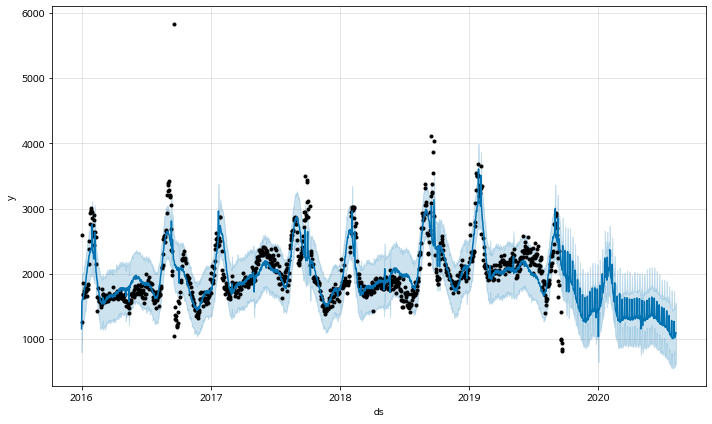

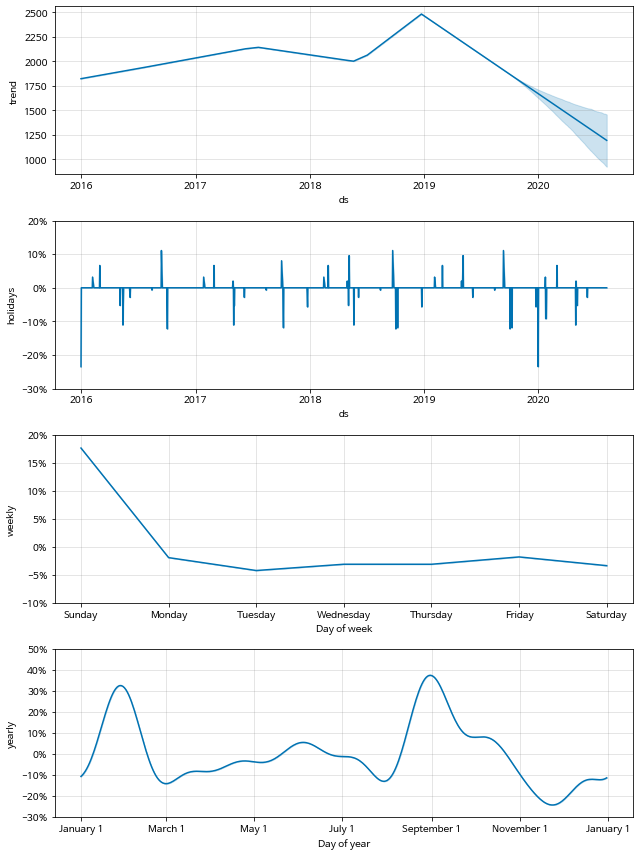

321 321
mean_absolute_percentage_error Error: 0.380


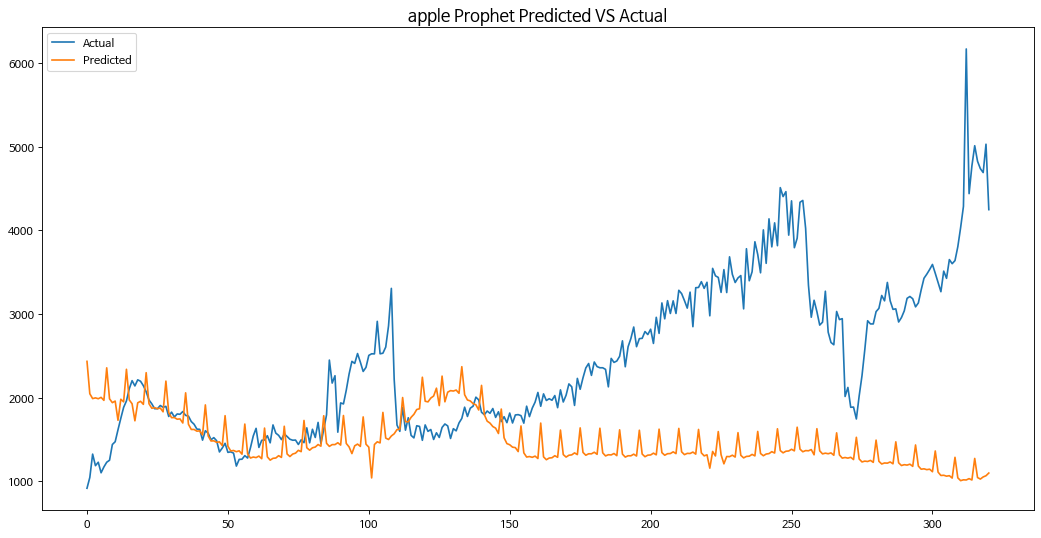

In [ ]:
# Setup and train model with holidays
prophet = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.03,
                      holidays_prior_scale = 1,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 15, 
                      n_changepoints = 25,
                      weekly_seasonality= 'auto',
                      daily_seasonality = 'auto',
                      yearly_seasonality = True,
                      interval_width=0.8)
prophet.add_country_holidays(country_name='KR')
prophet.fit(train)
future = prophet.make_future_dataframe(periods=test.shape[0])
forecast_tr = prophet.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

prophet.plot(forecast_tr)
plt.show()

prophet.plot_components(forecast_tr)
plt.show()

y_true= test['y'].values
y_pred = forecast_tr['yhat'][-len(y_true):].values
print(len(y_true), len(y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print('mean_absolute_percentage_error Error: %.3f' % mape)

#  Predicted vs Actual
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(test['y'].values, label='Actual')
plt.plot(forecast_tr['yhat'].values[-test.shape[0]:], label='Predicted')
plt.legend()
plt.title('apple Prophet Predicted VS Actual', fontsize = 15)
plt.show()